In [1]:
import pyPDMP.utils as utils
from pyPDMP.utils import HDSint

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from IPython import display
import os
from PIL import Image
from torch.utils.data.dataset import Dataset
from scipy.misc import imread

In [4]:
%matplotlib notebook

## Define Variables and parameters of the PDMP Model
ODE:
$$\begin{bmatrix}\dot{x}\\ \dot{v}\end{bmatrix} = \begin{bmatrix}v\\ -kx - bv\end{bmatrix}$$

In [7]:
k = 2 #
b = 2
x0 = [5,0]
t = np.linspace(0,10,1000)
Sigma = np.array([[5,0],[0,5]])
mu = np.array([0,0])
tau = 0.4
#
def fun(xi,t):
    x = xi[0]
    v = xi[1]
    return [xi[1],-k*xi[0]-b*xi[1]]

In [8]:
#
#import PDMPsim
Ttot, Xtot, Xevent, Xreset, C = HDSint(5000,t,fun,x0,mu,Sigma,tau)

Progress:
25.0
50.0
75.0
100.0


<IPython.core.display.Javascript object>


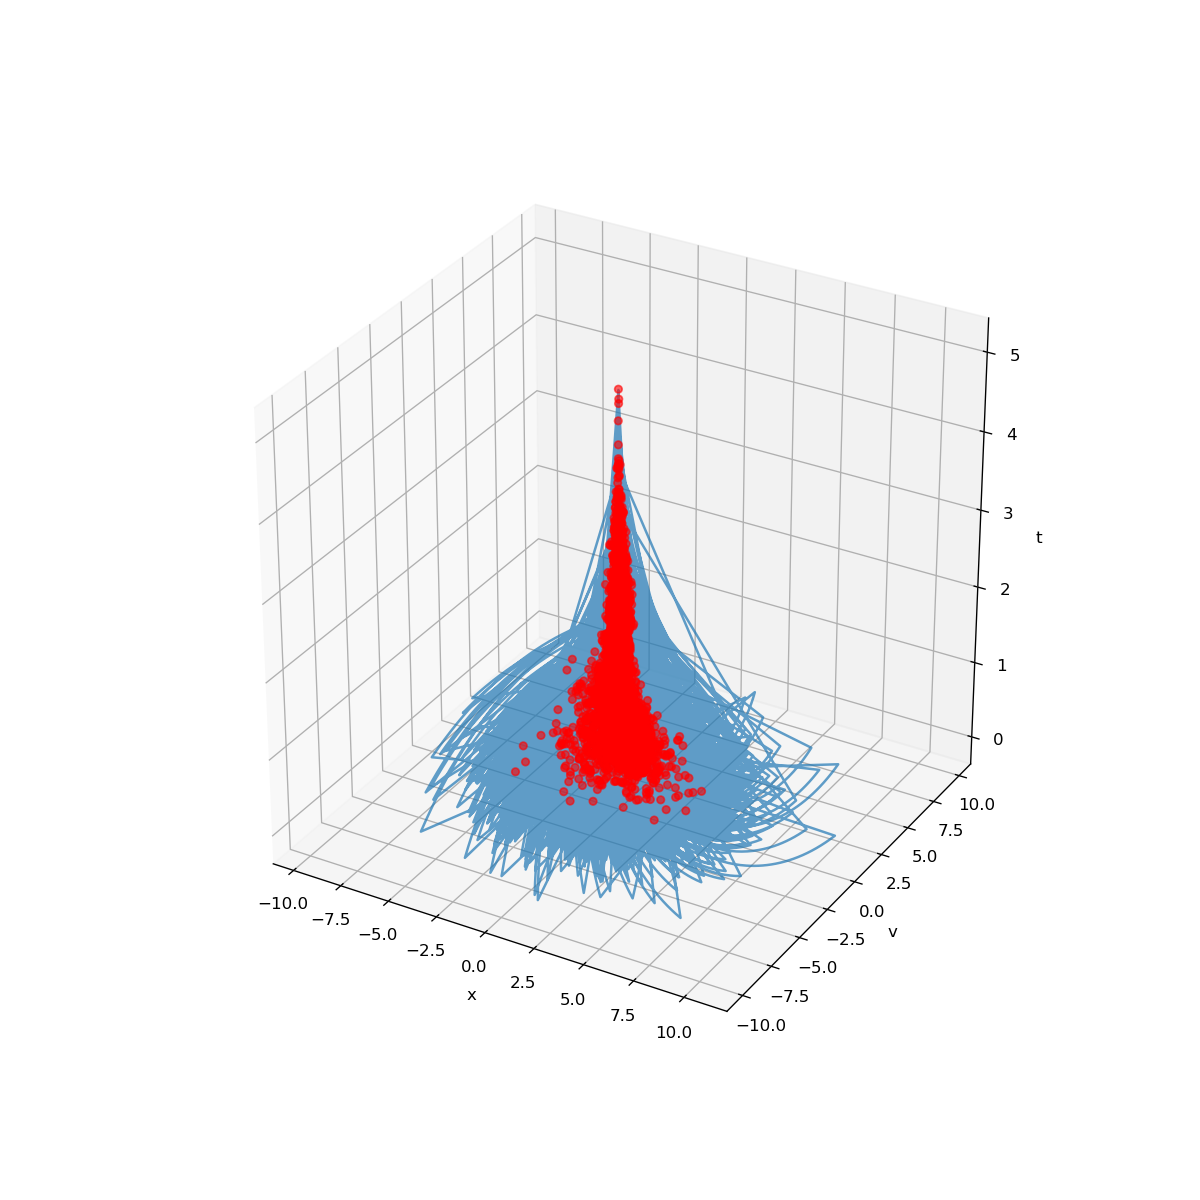

Text(0.5, 0, 't')

In [9]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize = (10,10))
ax = fig.gca(projection='3d')
ax.plot(xs = Xtot[:,0], ys = Xtot[:,1],zs = Xtot[:,2],alpha = 0.7)
ax.scatter(xs = Xevent[:,0], ys = Xevent[:,1],zs = Xevent[:,2],alpha = .6,color = 'red')
ax.set_xlabel('x')
ax.set_ylabel('v')
ax.set_zlabel('t')

In [33]:
Ci = utils.thin_flow_samples(C,2*len(Xevent))
# Create Labels
y1 = [1 for i in range(Xevent.shape[0])]
y2 = [0 for i in range(Ci.shape[0])]
y = np.hstack((y1,y2))
# Create whole dataset
X = np.vstack((Xevent,Ci))

print(X.shape,y.shape)

from sklearn.model_selection import train_test_split
#
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

(15000, 3) (15000,)


Text(0.5, 0, 't')

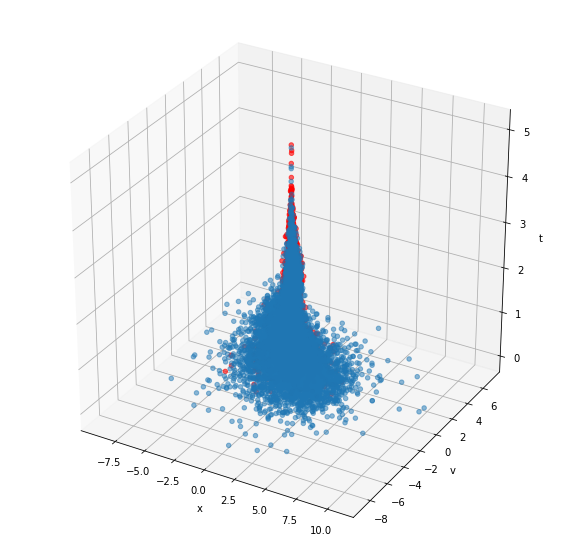

In [34]:
fig = plt.figure(figsize = (10,10))
ax = fig.gca(projection='3d')
ax.scatter(xs = Ci[:,0], ys = Ci[:,1],zs = Ci[:,2],alpha = .5)
ax.scatter(xs = Xevent[:,0], ys = Xevent[:,1],zs = Xevent[:,2],alpha = .6,color = 'red')
ax.set_xlabel('x')
ax.set_ylabel('v')
ax.set_zlabel('t')

In [35]:
# Prepare the dataset for the training
bs = 100#len(X_train)
import torch.utils.data as data_utils
X_train = torch.Tensor(X_train)
y_train = torch.Tensor(y_train)
X_test = torch.Tensor(X_test)
y_test = torch.Tensor(y_test)
#
train = data_utils.TensorDataset(X_train,y_train)
train_loader = torch.utils.data.DataLoader(train,batch_size=bs, shuffle=True)
#
test = data_utils.TensorDataset(X_test,y_test)
test_loader = torch.utils.data.DataLoader(test,batch_size=bs, shuffle=True)

In [36]:
class NN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(NN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        output = F.relu(self.fc1(x))
        output = F.relu(self.fc2(output))
        output = F.relu(self.fc3(output))
        output = self.out(output)
        return output

In [37]:
net = NN(3, 128, 2)

In [38]:
import pyro
from pyro.distributions import Normal, Categorical
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam

In [39]:
log_softmax = nn.LogSoftmax(dim=1)

In [44]:
def model(x_data, y_data):
    
    fc1w_prior = Normal(loc=torch.zeros_like(net.fc1.weight), scale=torch.ones_like(net.fc1.weight))
    fc1b_prior = Normal(loc=torch.zeros_like(net.fc1.bias), scale=torch.ones_like(net.fc1.bias))
    
    fc2w_prior = Normal(loc=torch.zeros_like(net.fc2.weight), scale=torch.ones_like(net.fc2.weight))
    fc2b_prior = Normal(loc=torch.zeros_like(net.fc2.bias), scale=torch.ones_like(net.fc2.bias))
    
    fc3w_prior = Normal(loc=torch.zeros_like(net.fc3.weight), scale=torch.ones_like(net.fc3.weight))
    fc3b_prior = Normal(loc=torch.zeros_like(net.fc3.bias), scale=torch.ones_like(net.fc3.bias))
    
    outw_prior = Normal(loc=torch.zeros_like(net.out.weight), scale=torch.ones_like(net.out.weight))
    outb_prior = Normal(loc=torch.zeros_like(net.out.bias), scale=torch.ones_like(net.out.bias))
    
    priors = {'fc1.weight': fc1w_prior, 'fc1.bias': fc1b_prior, 
              'fc2.weight': fc2w_prior, 'fc2.bias': fc2b_prior, 
              'fc3.weight': fc3w_prior, 'fc3.bias': fc3b_prior, 
              'out.weight': outw_prior, 'out.bias': outb_prior}
    # lift module parameters to random variables sampled from the priors
    lifted_module = pyro.random_module("module", net, priors)
    # sample a regressor (which also samples w and b)
    lifted_reg_model = lifted_module()
    
    lhat = log_softmax(lifted_reg_model(x_data))
    
    pyro.sample("obs", Categorical(logits=lhat), obs=y_data)

In [45]:
softplus = torch.nn.Softplus()

def guide(x_data, y_data):
    
    # First layer weight distribution priors
    fc1w_mu = torch.randn_like(net.fc1.weight)
    fc1w_sigma = torch.randn_like(net.fc1.weight)
    fc1w_mu_param = pyro.param("fc1w_mu", fc1w_mu)
    fc1w_sigma_param = softplus(pyro.param("fc1w_sigma", fc1w_sigma))
    fc1w_prior = Normal(loc=fc1w_mu_param, scale=fc1w_sigma_param)
    # First layer bias distribution priors
    fc1b_mu = torch.randn_like(net.fc1.bias)
    fc1b_sigma = torch.randn_like(net.fc1.bias)
    fc1b_mu_param = pyro.param("fc1b_mu", fc1b_mu)
    fc1b_sigma_param = softplus(pyro.param("fc1b_sigma", fc1b_sigma))
    fc1b_prior = Normal(loc=fc1b_mu_param, scale=fc1b_sigma_param)
    # Second layer weight distribution priors
    fc2w_mu = torch.randn_like(net.fc2.weight)
    fc2w_sigma = torch.randn_like(net.fc2.weight)
    fc2w_mu_param = pyro.param("fc2w_mu", fc2w_mu)
    fc2w_sigma_param = softplus(pyro.param("fc2w_sigma", fc2w_sigma))
    fc2w_prior = Normal(loc=fc2w_mu_param, scale=fc2w_sigma_param)
    # Second layer bias distribution priors
    fc2b_mu = torch.randn_like(net.fc2.bias)
    fc2b_sigma = torch.randn_like(net.fc2.bias)
    fc2b_mu_param = pyro.param("fc2b_mu", fc2b_mu)
    fc2b_sigma_param = softplus(pyro.param("fc2b_sigma", fc2b_sigma))
    fc2b_prior = Normal(loc=fc2b_mu_param, scale=fc2b_sigma_param)
    # Third layer weight distribution priors
    fc3w_mu = torch.randn_like(net.fc3.weight)
    fc3w_sigma = torch.randn_like(net.fc3.weight)
    fc3w_mu_param = pyro.param("fc3w_mu", fc3w_mu)
    fc3w_sigma_param = softplus(pyro.param("fc3w_sigma", fc3w_sigma))
    fc3w_prior = Normal(loc=fc3w_mu_param, scale=fc3w_sigma_param)
    # Third layer bias distribution priors
    fc3b_mu = torch.randn_like(net.fc3.bias)
    fc3b_sigma = torch.randn_like(net.fc3.bias)
    fc3b_mu_param = pyro.param("fc3b_mu", fc3b_mu)
    fc3b_sigma_param = softplus(pyro.param("fc3b_sigma", fc3b_sigma))
    fc3b_prior = Normal(loc=fc3b_mu_param, scale=fc3b_sigma_param)
    # Output layer weight distribution priors
    outw_mu = torch.randn_like(net.out.weight)
    outw_sigma = torch.randn_like(net.out.weight)
    outw_mu_param = pyro.param("outw_mu", outw_mu)
    outw_sigma_param = softplus(pyro.param("outw_sigma", outw_sigma))
    outw_prior = Normal(loc=outw_mu_param, scale=outw_sigma_param).independent(1)
    # Output layer bias distribution priors
    outb_mu = torch.randn_like(net.out.bias)
    outb_sigma = torch.randn_like(net.out.bias)
    outb_mu_param = pyro.param("outb_mu", outb_mu)
    outb_sigma_param = softplus(pyro.param("outb_sigma", outb_sigma))
    outb_prior = Normal(loc=outb_mu_param, scale=outb_sigma_param)
    priors = {'fc1.weight': fc1w_prior, 'fc1.bias': fc1b_prior,
              'fc2.weight': fc2w_prior, 'fc2.bias': fc2b_prior, 
              'fc3.weight': fc3w_prior, 'fc3.bias': fc3b_prior, 
              'out.weight': outw_prior, 'out.bias': outb_prior}
    
    lifted_module = pyro.random_module("module", net, priors)
    
    return lifted_module()

In [46]:
optim = Adam({"lr": 0.01})
svi = SVI(model, guide, optim, loss=Trace_ELBO())

In [47]:
num_iterations = 50
loss = 0
L = []
for j in range(num_iterations):
    loss = 0
    for batch_id, data in enumerate(train_loader):
        # calculate the loss and take a gradient step
        loss += svi.step(data[0].view(-1,3), data[1])
    normalizer_train = len(train_loader.dataset)
    total_epoch_loss_train = loss / normalizer_train
    L.append(total_epoch_loss_train)
    print("Epoch ", j, " Loss ", total_epoch_loss_train)

Epoch  0  Loss  1286.6029740945796
Epoch  1  Loss  803.5151020938158
Epoch  2  Loss  640.2711511989783
Epoch  3  Loss  516.4264746941825
Epoch  4  Loss  466.26335127680994
Epoch  5  Loss  422.43411374511817
Epoch  6  Loss  378.738721953541
Epoch  7  Loss  353.7902447346151
Epoch  8  Loss  326.6326283255915
Epoch  9  Loss  303.6119851498554
Epoch  10  Loss  280.53644922510284
Epoch  11  Loss  261.8947313435624
Epoch  12  Loss  242.88652701498071
Epoch  13  Loss  233.20600616416334
Epoch  14  Loss  221.59381774883468
Epoch  15  Loss  211.2550297433883
Epoch  16  Loss  202.08044620888433
Epoch  17  Loss  192.7966788751334
Epoch  18  Loss  182.11438558926184
Epoch  19  Loss  173.7489801992625
Epoch  20  Loss  164.33320870086055
Epoch  21  Loss  156.14618646252154
Epoch  22  Loss  147.24196584047874
Epoch  23  Loss  138.8811321140329
Epoch  24  Loss  130.48491518200439
Epoch  25  Loss  123.53847612009943
Epoch  26  Loss  114.56244998913506
Epoch  27  Loss  107.15567905656496
Epoch  28  Loss

In [70]:
num_samples = 100
def predict(x):
    sampled_models = [guide(None, None) for _ in range(num_samples)]
    yhats = [model(x).data for model in sampled_models]
    mean = torch.mean(torch.stack(yhats), 0)
    return np.argmax(mean.numpy(), axis=1)

print('Prediction when network is forced to predict')
correct = 0
total = 0
for j, data in enumerate(test_loader):
    inputs, labels = data
    predicted = torch.tensor(predict(inputs.view(-1,3)))
    total += labels.size(0)
    correct += (predicted.float() == labels).sum().item()
print("accuracy: %d %%" % (100 * correct / total))

Prediction when network is forced to predict
accuracy: 61 %


In [75]:
predict(inputs)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

In [24]:
classes = ('jump', 'flow')

In [25]:
num_samples = 100
def give_uncertainities(x):
    sampled_models = [guide(None, None) for _ in range(num_samples)]
    yhats = [F.log_softmax(model(x.view(-1,3)).data, 1).detach().numpy() for model in sampled_models]
    return np.asarray(yhats)

In [26]:
def test_batch(inputs, labels, plot=True):
    y = give_uncertainities(inputs)
    predicted_for_inputs = 0
    correct_predictions = 0
    for i in range(2):
        if(plot):
            print("Real: ",labels[i].item())
            fig, axs = plt.subplots(1, 2, sharey=True,figsize=(20,2))
    
        all_digits_prob = []
    
        highted_something = False
    
        for j in range(len(classes)):
        
            highlight=False
        
            histo = []
            histo_exp = []
        
            for z in range(y.shape[0]):
                histo.append(y[z][i][j])
                histo_exp.append(np.exp(y[z][i][j]))
            
            prob = np.percentile(histo_exp, 50) #sampling median probability
        
            if(prob>0.2): #select if network thinks this sample is 20% chance of this being a label
                highlight = True #possibly an answer
        
            all_digits_prob.append(prob)
            
            if(plot):
            
                N, bins, patches = axs[j].hist(histo, bins=8, color = "lightgray", lw=0,  weights=np.ones(len(histo)) / len(histo), density=False)
                axs[j].set_title(str(j)+" ("+str(round(prob,2))+")") 
        
            if(highlight):
            
                highted_something = True
                
                if(plot):

                    # We'll color code by height, but you could use any scalar
                    fracs = N / N.max()

                    # we need to normalize the data to 0..1 for the full range of the colormap
                    norm = colors.Normalize(fracs.min(), fracs.max())

                    # Now, we'll loop through our objects and set the color of each accordingly
                    for thisfrac, thispatch in zip(fracs, patches):
                        color = plt.cm.viridis(norm(thisfrac))
                        thispatch.set_facecolor(color)

    
        if(plot):
            plt.show()
    
        predicted = np.argmax(all_digits_prob)
    
        if(highted_something):
            predicted_for_inputs+=1
            if(labels[i].item()==predicted):
                if(plot):
                    print("Correct")
                correct_predictions +=1.0
            else:
                if(plot):
                    print("Incorrect :()")
        else:
            if(plot):
                print("Undecided.")
        
        #if(plot):
            #imshow(images[i].squeeze())
        
    
    if(plot):
        print("Summary")
        print("Total images: ",len(labels))
        print("Predicted for: ",predicted_for_inputs)
        print("Accuracy when predicted: ",correct_predictions/predicted_for_inputs)
        
    return len(labels), correct_predictions, predicted_for_inputs 
    

Prediction when network can refuse
Real:  0.0


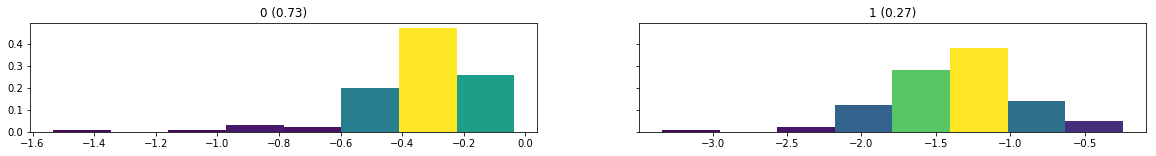

Correct
Real:  0.0


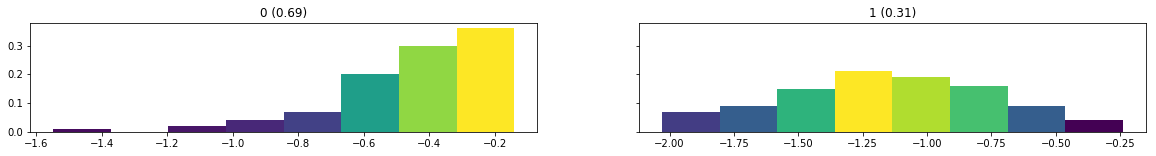

Correct
Summary
Total images:  100
Predicted for:  2
Accuracy when predicted:  1.0
Real:  1.0


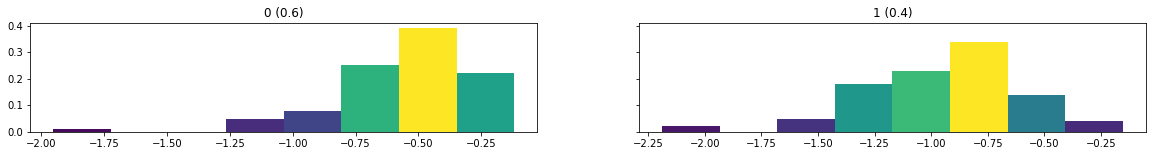

Incorrect :()
Real:  1.0


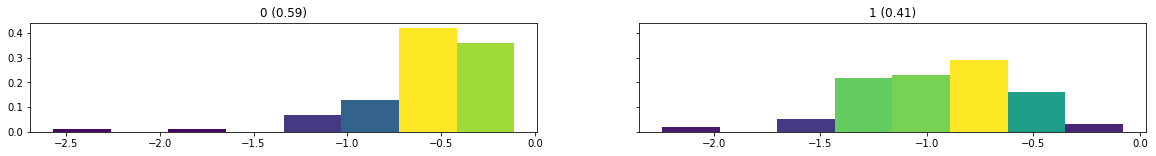

Incorrect :()
Summary
Total images:  100
Predicted for:  2
Accuracy when predicted:  0.0
Real:  0.0


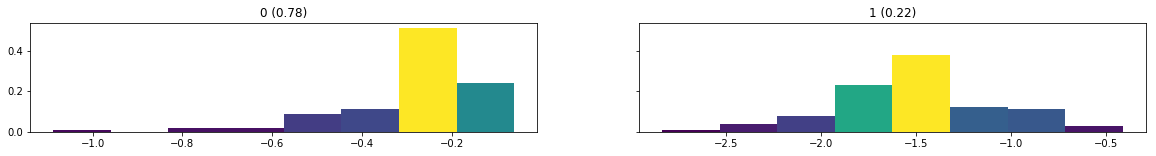

Correct
Real:  0.0


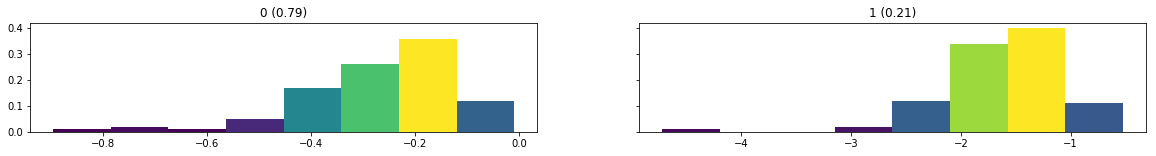

Correct
Summary
Total images:  100
Predicted for:  2
Accuracy when predicted:  1.0
Real:  1.0


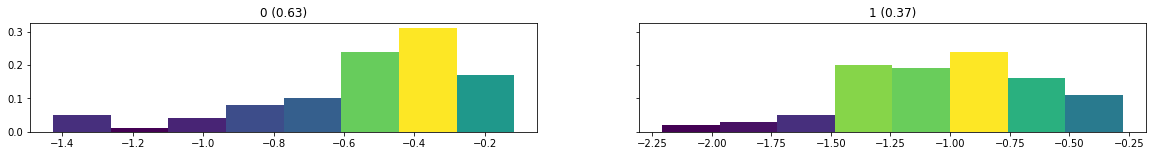

Incorrect :()
Real:  0.0


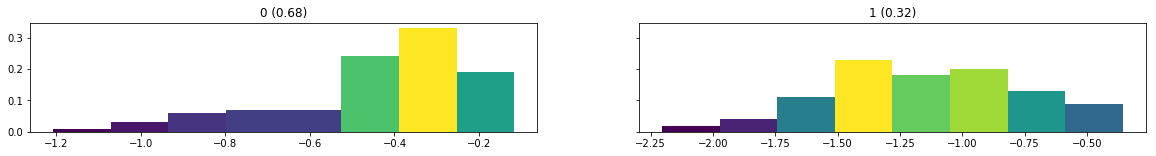

Correct
Summary
Total images:  100
Predicted for:  2
Accuracy when predicted:  0.5
Real:  0.0


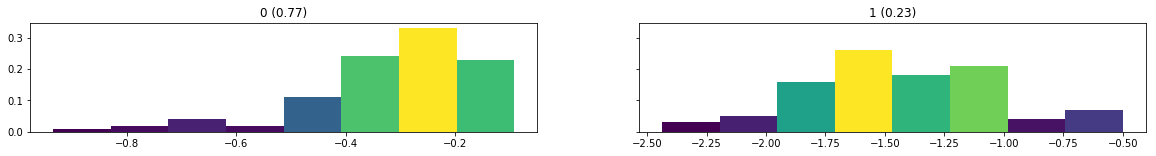

Correct
Real:  0.0


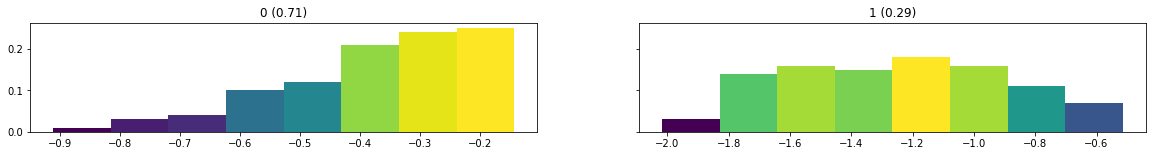

Correct
Summary
Total images:  100
Predicted for:  2
Accuracy when predicted:  1.0
Real:  0.0


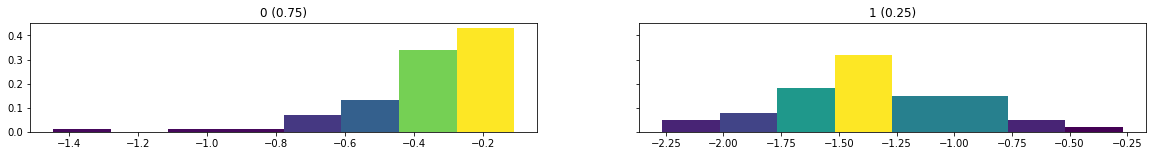

Correct
Real:  0.0


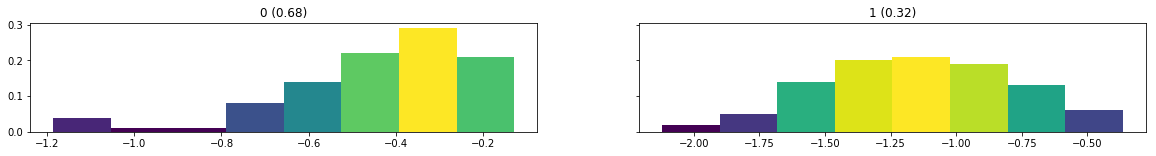

Correct
Summary
Total images:  100
Predicted for:  2
Accuracy when predicted:  1.0
Real:  1.0


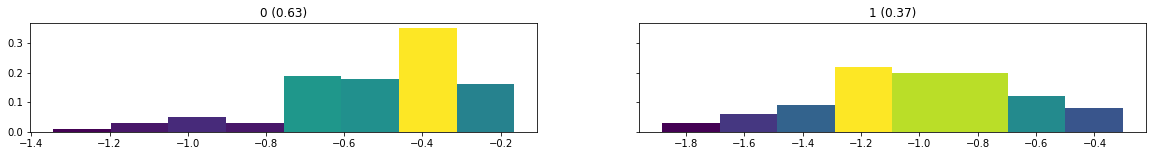

Incorrect :()
Real:  0.0


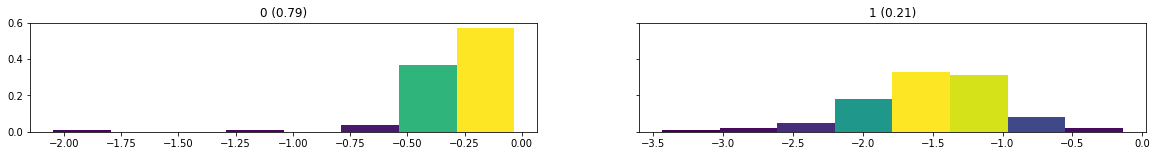

Correct
Summary
Total images:  100
Predicted for:  2
Accuracy when predicted:  0.5
Real:  0.0


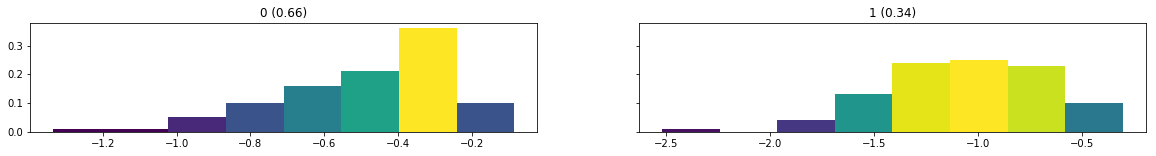

Correct
Real:  0.0


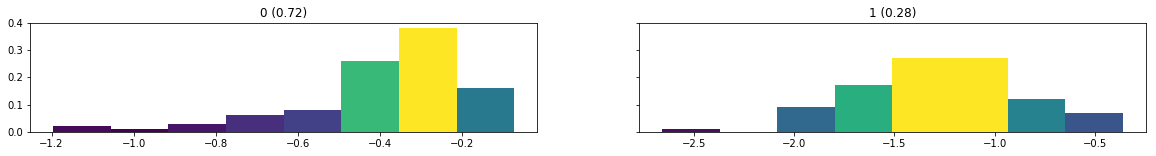

Correct
Summary
Total images:  100
Predicted for:  2
Accuracy when predicted:  1.0
Real:  0.0


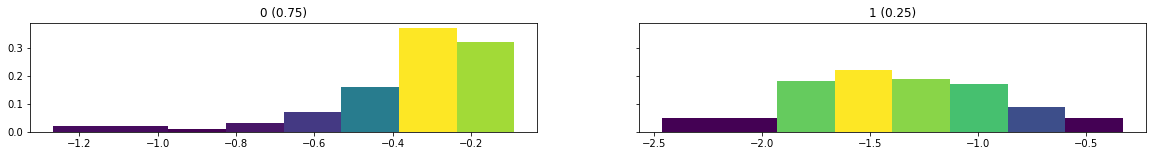

Correct
Real:  0.0


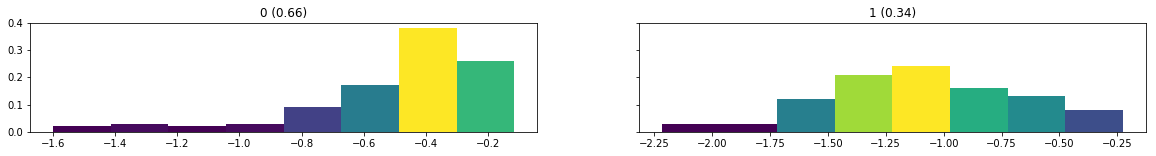

Correct
Summary
Total images:  100
Predicted for:  2
Accuracy when predicted:  1.0
Real:  0.0


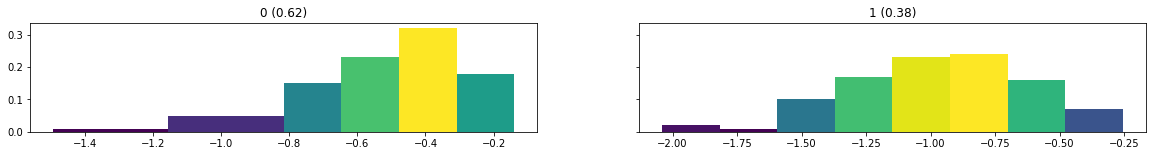

Correct
Real:  0.0


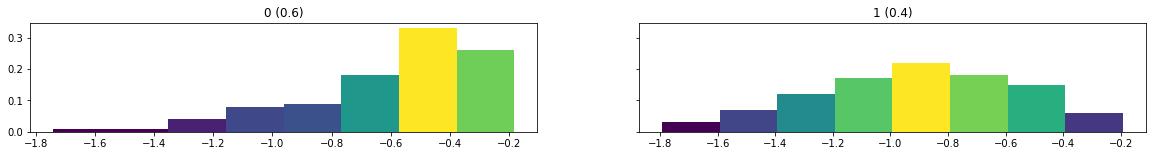

Correct
Summary
Total images:  100
Predicted for:  2
Accuracy when predicted:  1.0
Real:  1.0


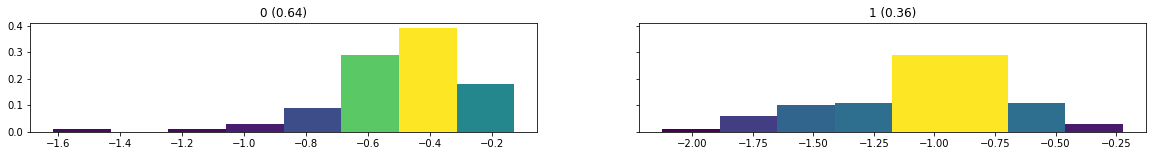

Incorrect :()
Real:  0.0


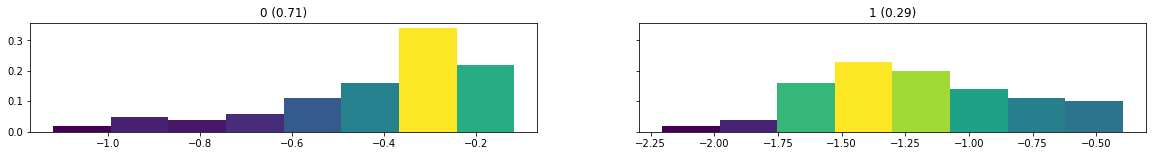

Correct
Summary
Total images:  100
Predicted for:  2
Accuracy when predicted:  0.5
Real:  0.0


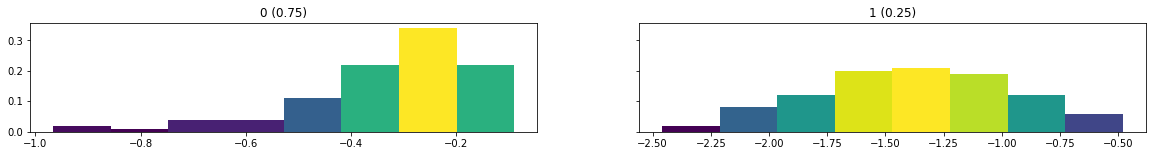

Correct
Real:  1.0


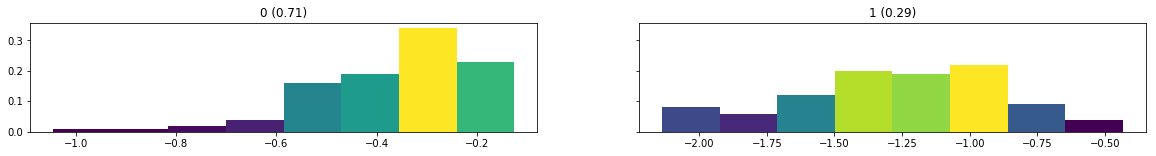

Incorrect :()
Summary
Total images:  100
Predicted for:  2
Accuracy when predicted:  0.5
Real:  0.0


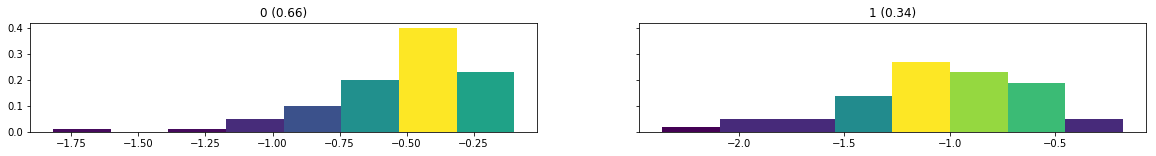

Correct
Real:  0.0


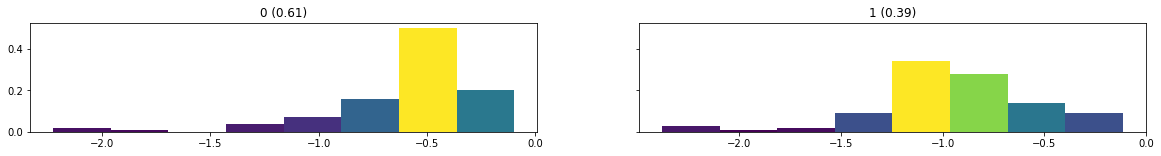

Correct
Summary
Total images:  100
Predicted for:  2
Accuracy when predicted:  1.0
Real:  0.0


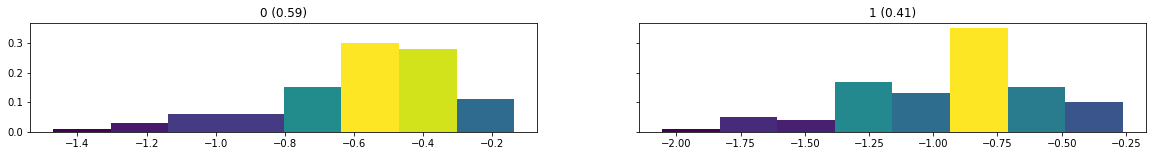

Correct
Real:  0.0


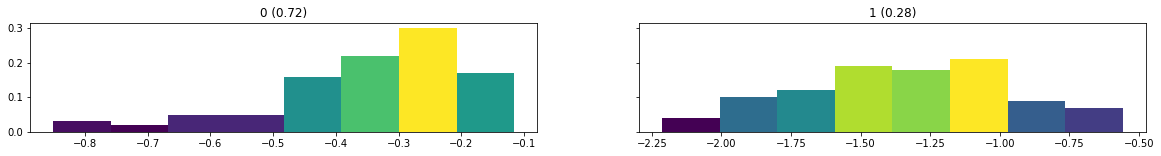

Correct
Summary
Total images:  100
Predicted for:  2
Accuracy when predicted:  1.0
Real:  1.0


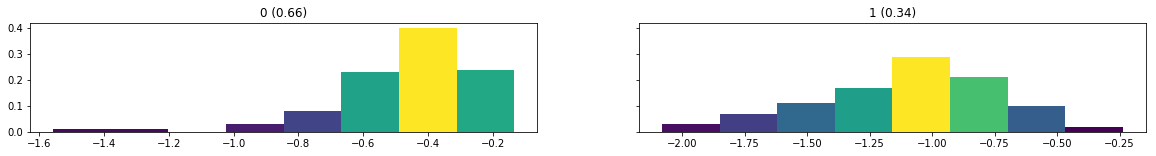

Incorrect :()
Real:  0.0


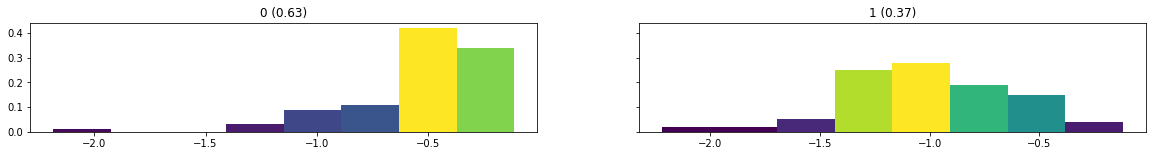

Correct
Summary
Total images:  100
Predicted for:  2
Accuracy when predicted:  0.5
Real:  0.0


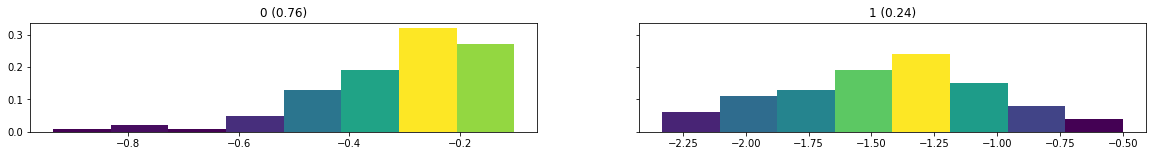

Correct
Real:  0.0


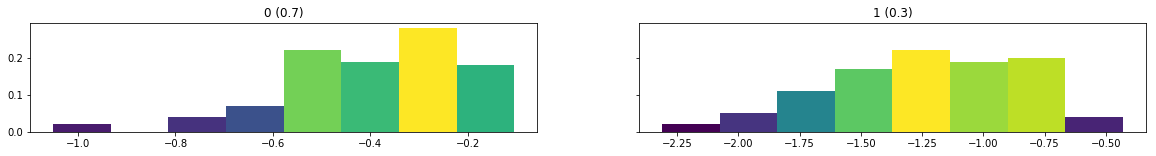

Correct
Summary
Total images:  100
Predicted for:  2
Accuracy when predicted:  1.0
Real:  1.0


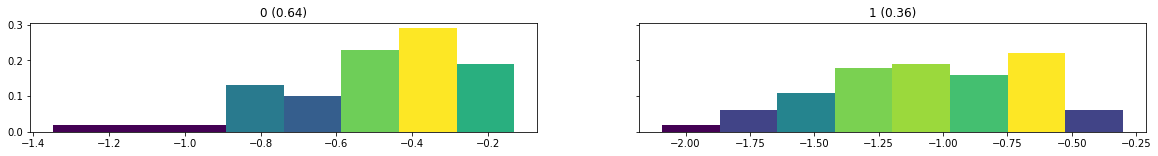

Incorrect :()
Real:  1.0


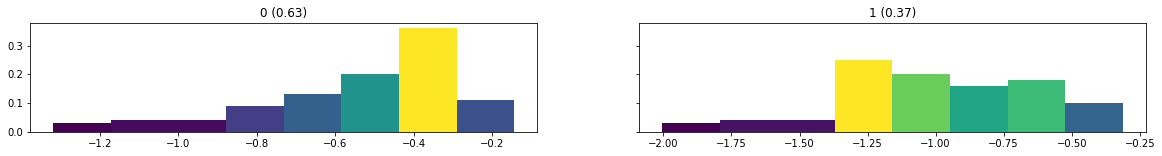

Incorrect :()
Summary
Total images:  100
Predicted for:  2
Accuracy when predicted:  0.0
Real:  0.0


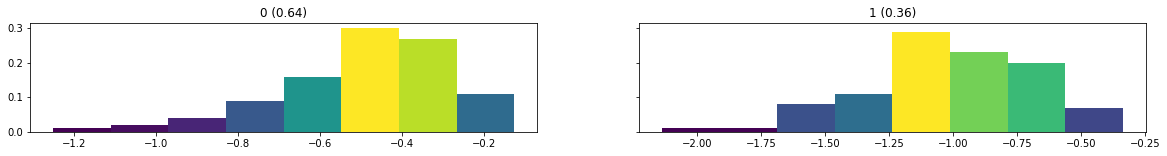

Correct
Real:  1.0


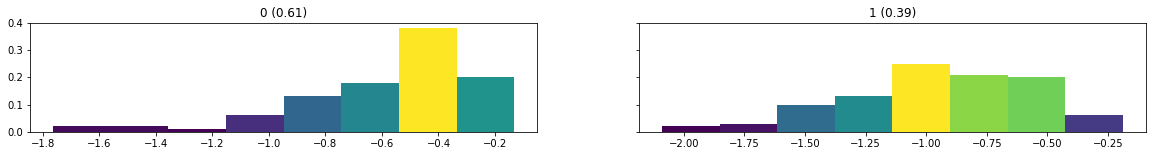

Incorrect :()
Summary
Total images:  100
Predicted for:  2
Accuracy when predicted:  0.5
Real:  0.0


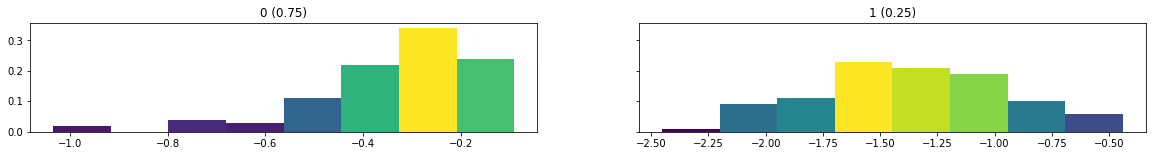

Correct
Real:  1.0


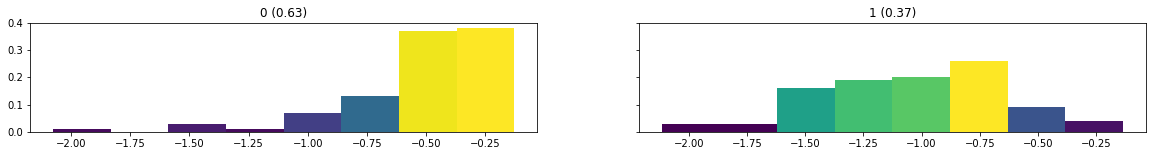

Incorrect :()
Summary
Total images:  100
Predicted for:  2
Accuracy when predicted:  0.5
Real:  0.0


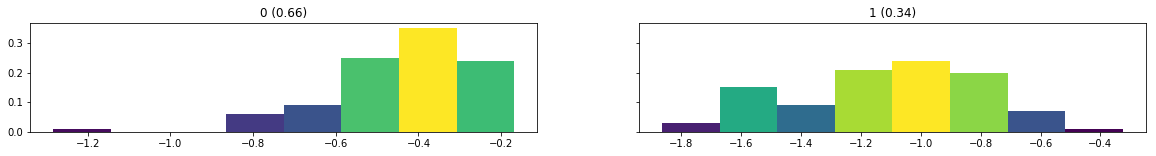

Correct
Real:  1.0


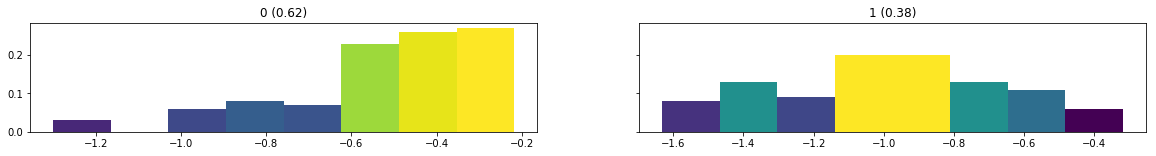

Incorrect :()
Summary
Total images:  100
Predicted for:  2
Accuracy when predicted:  0.5
Real:  0.0


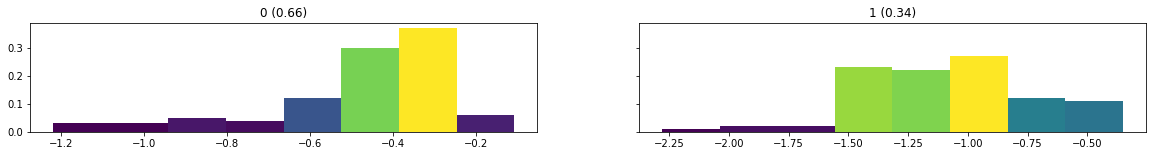

Correct
Real:  0.0


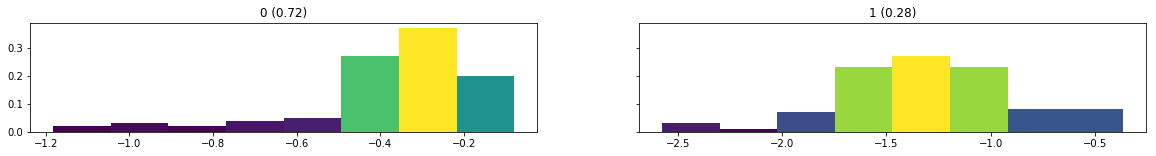

Correct
Summary
Total images:  100
Predicted for:  2
Accuracy when predicted:  1.0
Real:  0.0


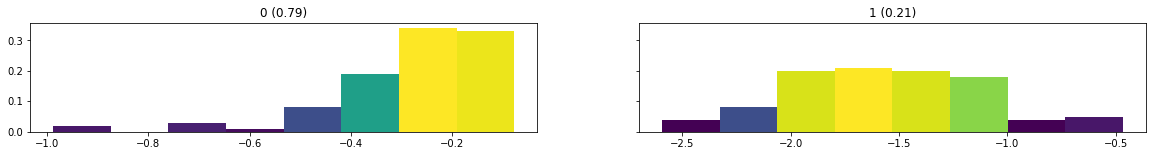

Correct
Real:  0.0


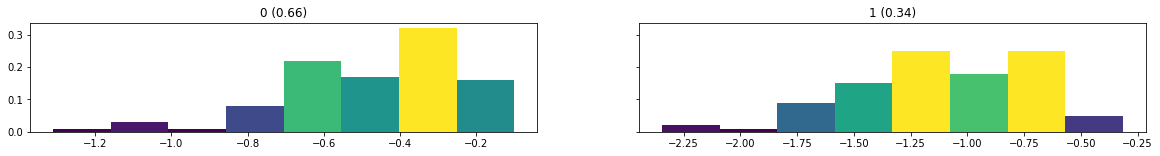

Correct
Summary
Total images:  100
Predicted for:  2
Accuracy when predicted:  1.0
Real:  0.0


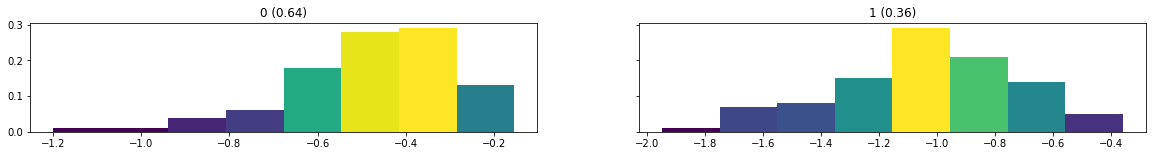

Correct
Real:  0.0


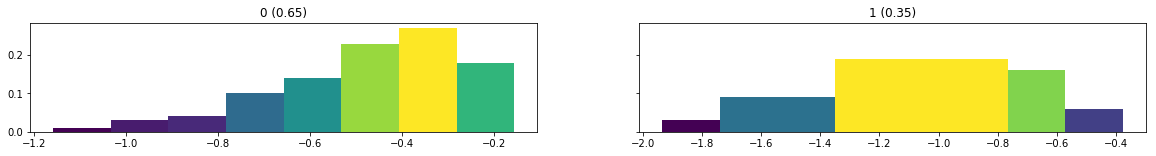

Correct
Summary
Total images:  100
Predicted for:  2
Accuracy when predicted:  1.0
Real:  1.0


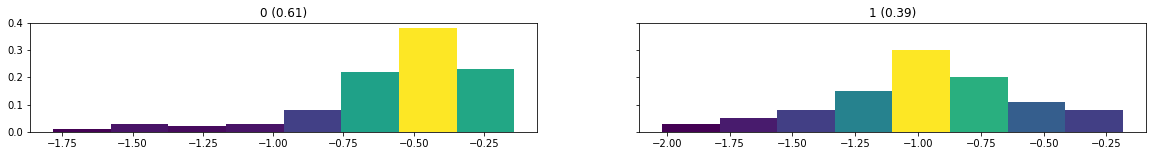

Incorrect :()
Real:  1.0


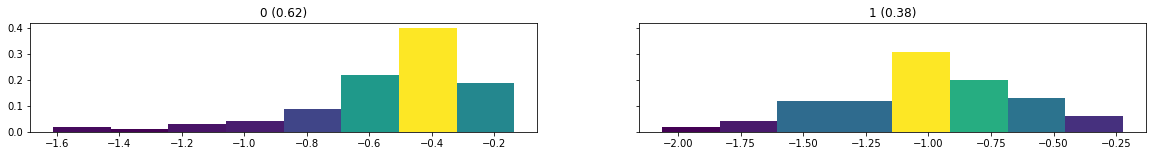

Incorrect :()
Summary
Total images:  100
Predicted for:  2
Accuracy when predicted:  0.0
Real:  0.0


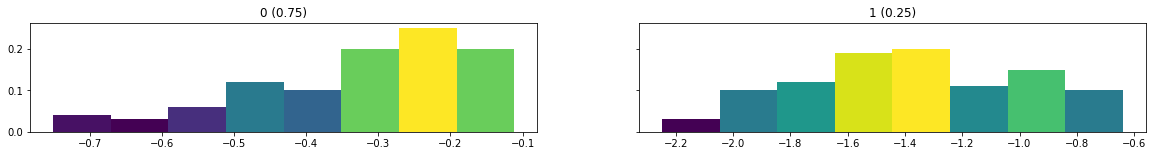

Correct
Real:  0.0


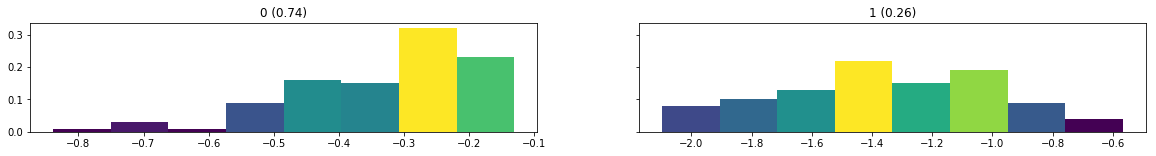

Correct
Summary
Total images:  100
Predicted for:  2
Accuracy when predicted:  1.0
Real:  1.0


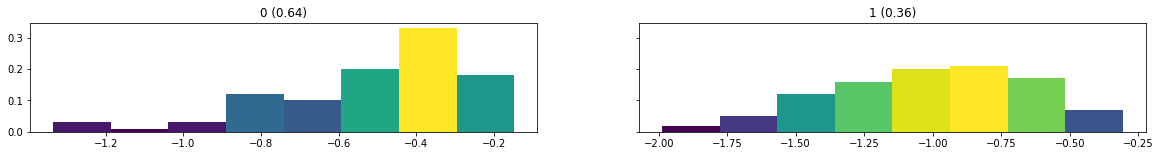

Incorrect :()
Real:  0.0


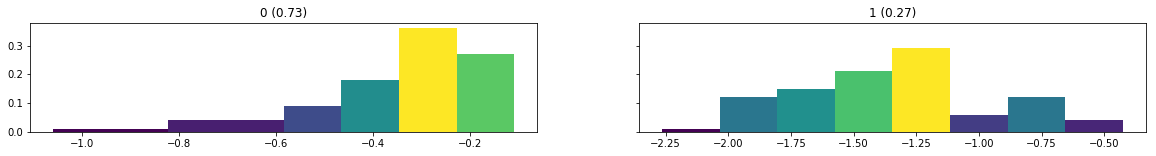

Correct
Summary
Total images:  100
Predicted for:  2
Accuracy when predicted:  0.5
Real:  0.0


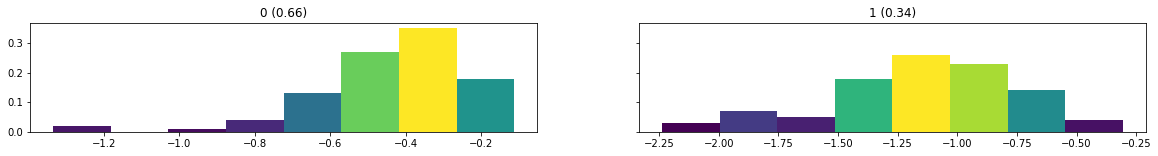

Correct
Real:  0.0


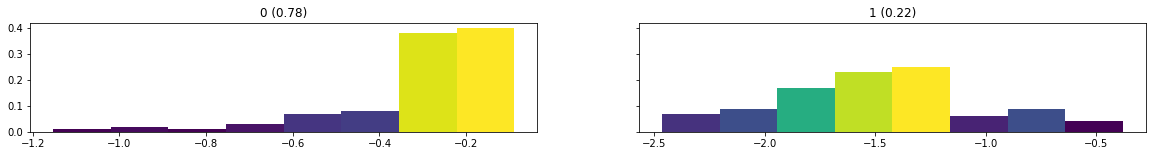

Correct
Summary
Total images:  100
Predicted for:  2
Accuracy when predicted:  1.0
Real:  0.0


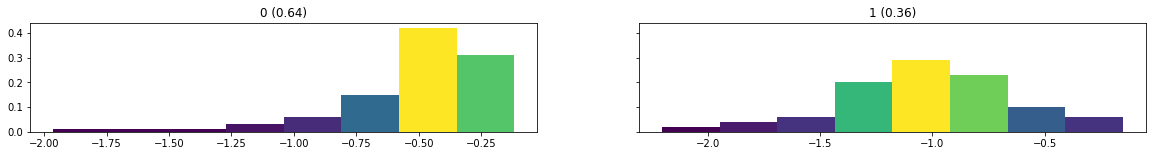

Correct
Real:  0.0


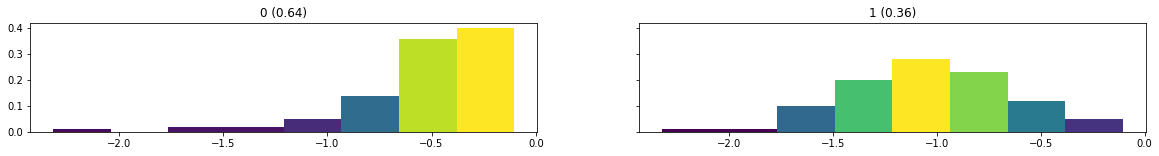

Correct
Summary
Total images:  100
Predicted for:  2
Accuracy when predicted:  1.0
Real:  1.0


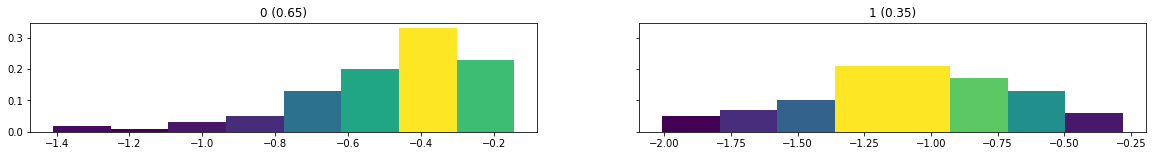

Incorrect :()
Real:  0.0


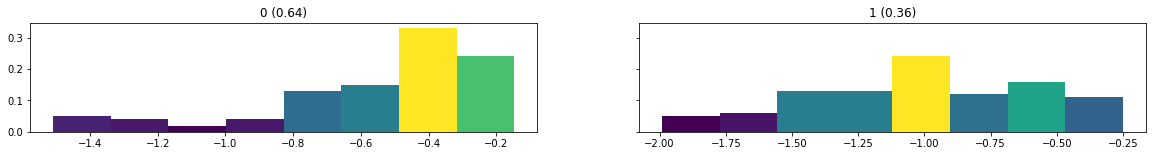

Correct
Summary
Total images:  100
Predicted for:  2
Accuracy when predicted:  0.5
Real:  0.0


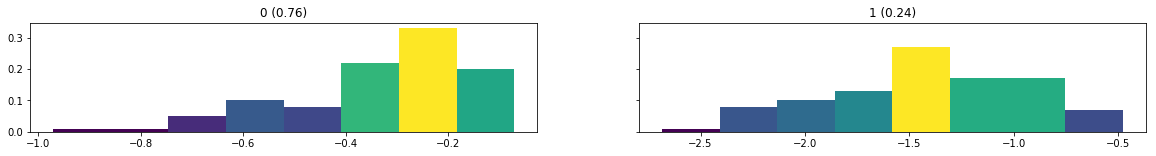

Correct
Real:  1.0


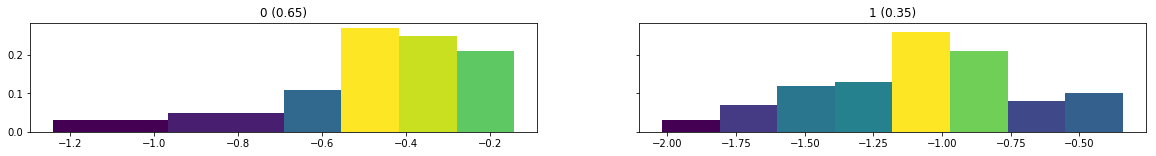

Incorrect :()
Summary
Total images:  100
Predicted for:  2
Accuracy when predicted:  0.5
Real:  0.0


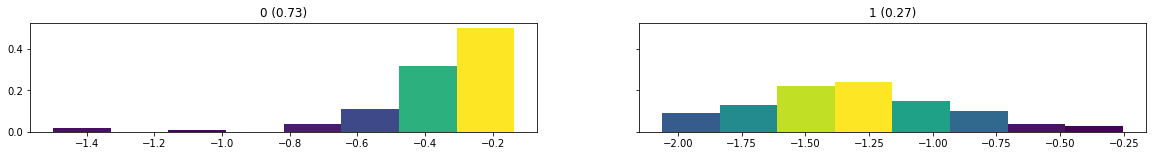

Correct
Real:  0.0


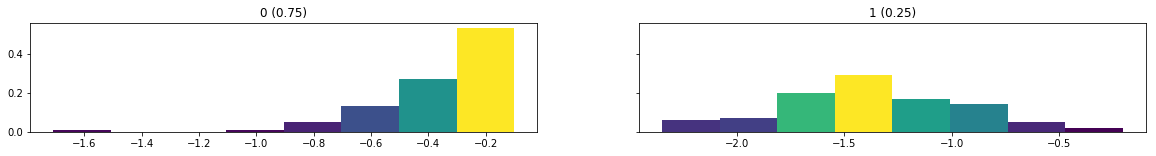

Correct
Summary
Total images:  100
Predicted for:  2
Accuracy when predicted:  1.0
Real:  0.0


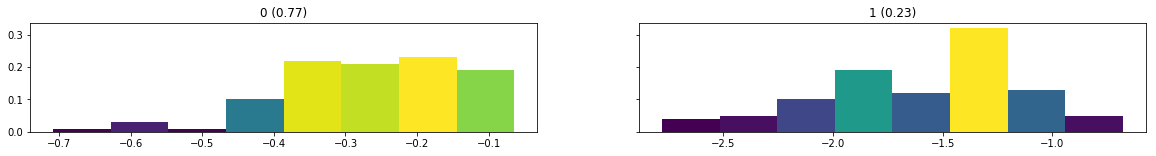

Correct
Real:  0.0


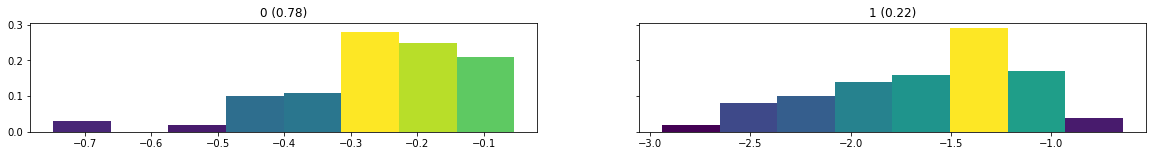

Correct
Summary
Total images:  100
Predicted for:  2
Accuracy when predicted:  1.0
Real:  1.0


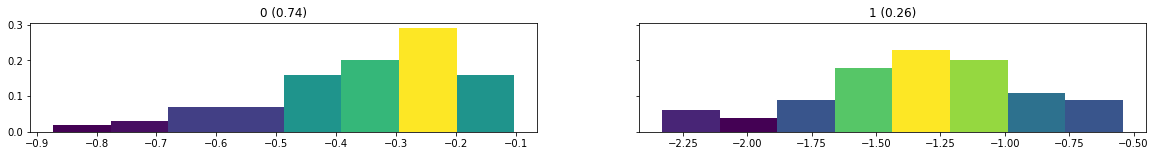

Incorrect :()
Real:  1.0


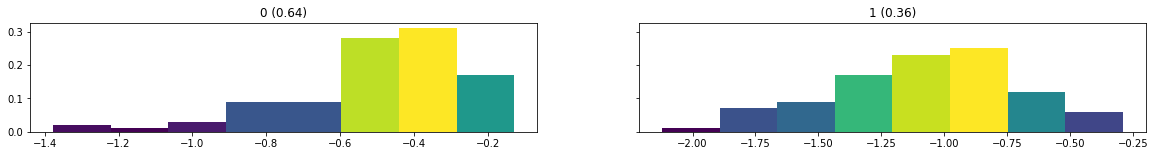

Incorrect :()
Summary
Total images:  100
Predicted for:  2
Accuracy when predicted:  0.0
Real:  0.0


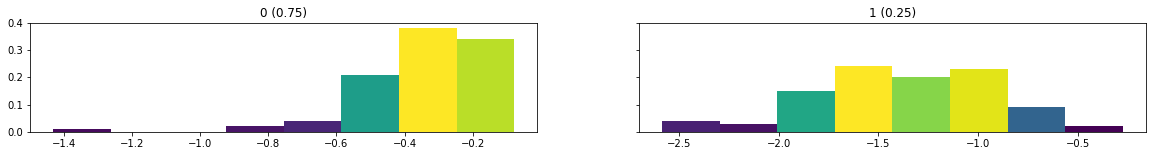

Correct
Real:  0.0


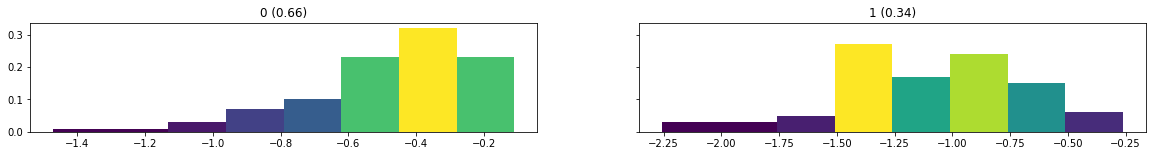

Correct
Summary
Total images:  100
Predicted for:  2
Accuracy when predicted:  1.0
Real:  0.0


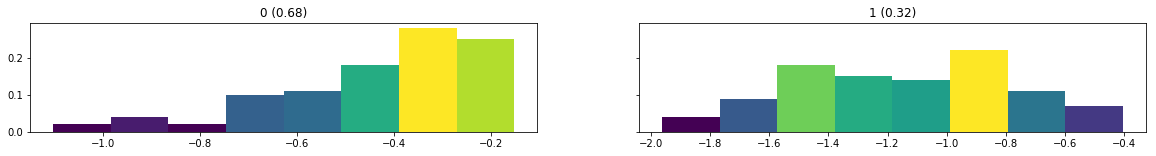

Correct
Real:  0.0


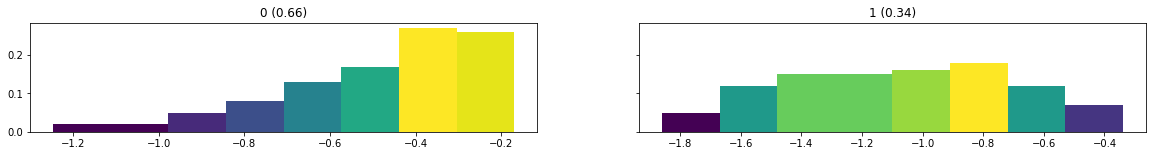

Correct
Summary
Total images:  100
Predicted for:  2
Accuracy when predicted:  1.0
Real:  1.0


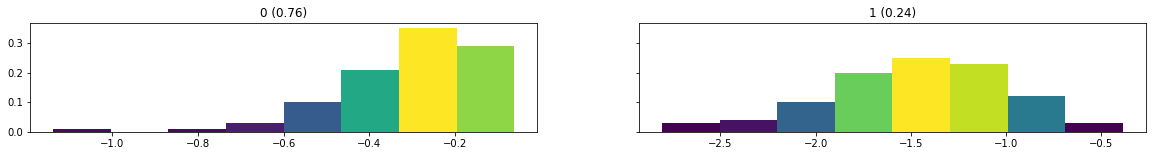

Incorrect :()
Real:  0.0


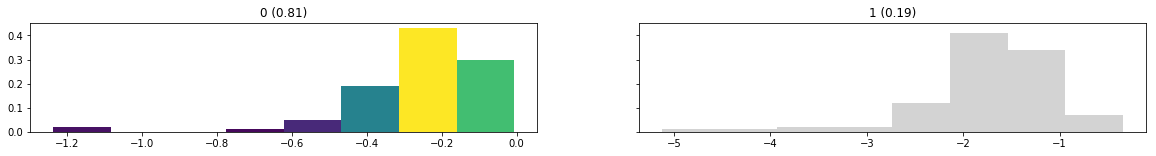

Correct
Summary
Total images:  100
Predicted for:  2
Accuracy when predicted:  0.5
Real:  0.0


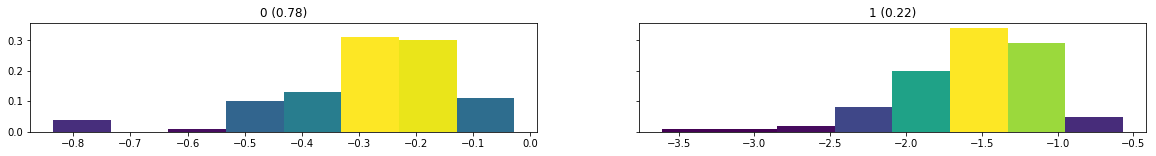

Correct
Real:  0.0


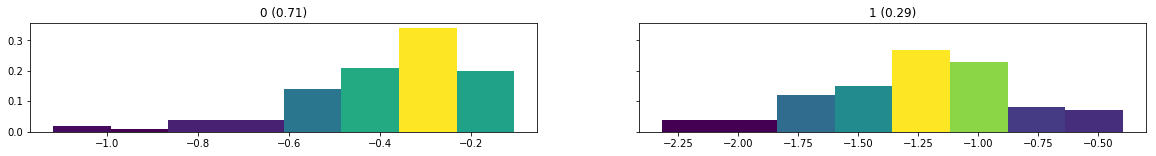

Correct
Summary
Total images:  100
Predicted for:  2
Accuracy when predicted:  1.0
Real:  1.0


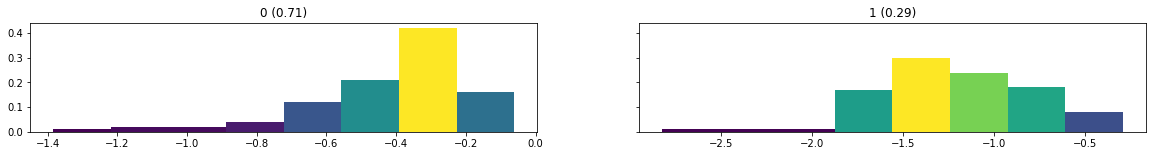

Incorrect :()
Real:  0.0


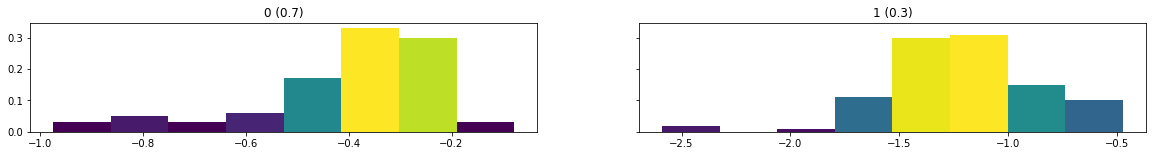

Correct
Summary
Total images:  100
Predicted for:  2
Accuracy when predicted:  0.5
Real:  0.0


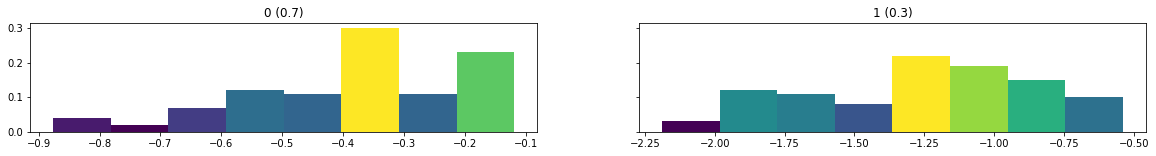

Correct
Real:  0.0


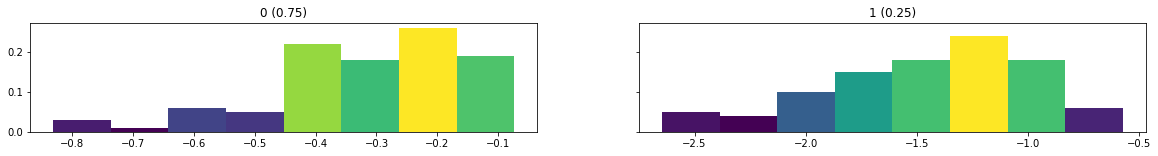

Correct
Summary
Total images:  100
Predicted for:  2
Accuracy when predicted:  1.0
Real:  0.0


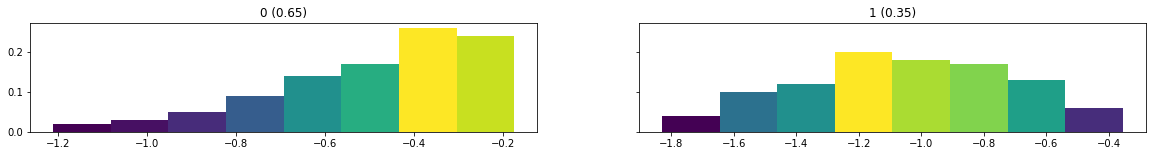

Correct
Real:  0.0


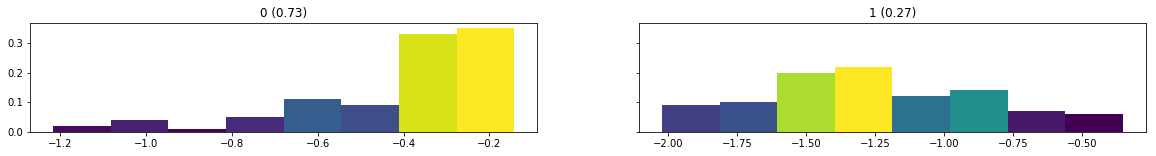

Correct
Summary
Total images:  100
Predicted for:  2
Accuracy when predicted:  1.0
Real:  0.0


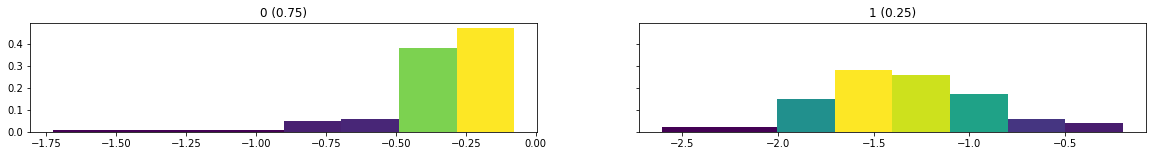

Correct
Real:  1.0


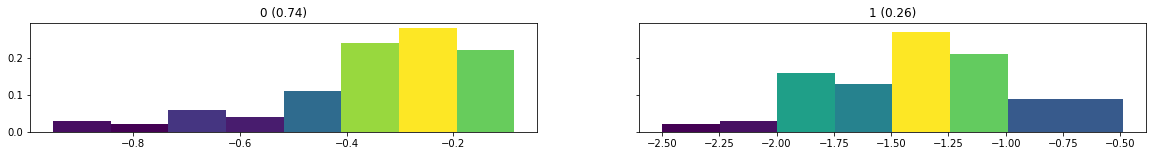

Incorrect :()
Summary
Total images:  100
Predicted for:  2
Accuracy when predicted:  0.5
Real:  1.0


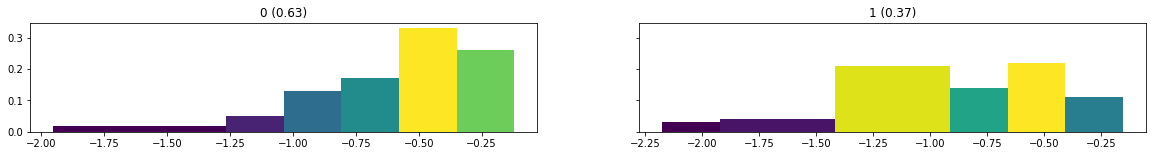

Incorrect :()
Real:  0.0


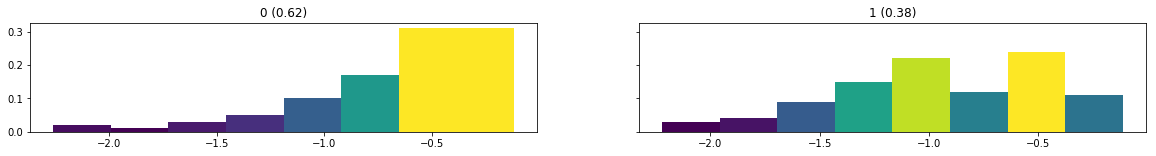

Correct
Summary
Total images:  100
Predicted for:  2
Accuracy when predicted:  0.5
Real:  0.0


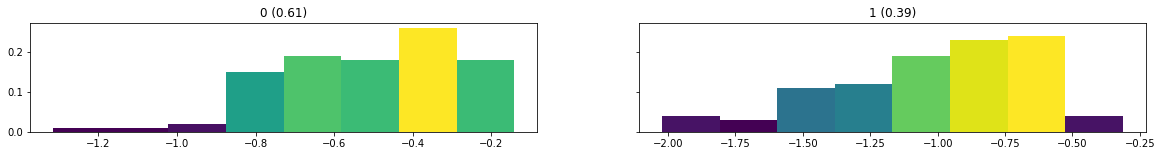

Correct
Real:  1.0


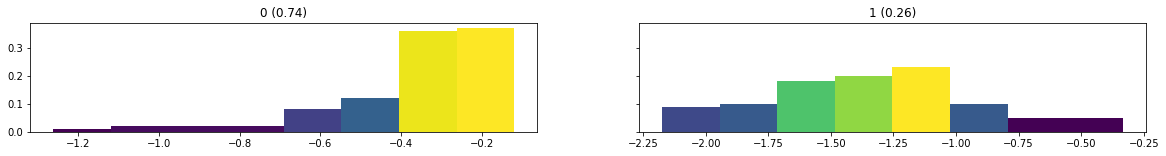

Incorrect :()
Summary
Total images:  100
Predicted for:  2
Accuracy when predicted:  0.5
Real:  0.0


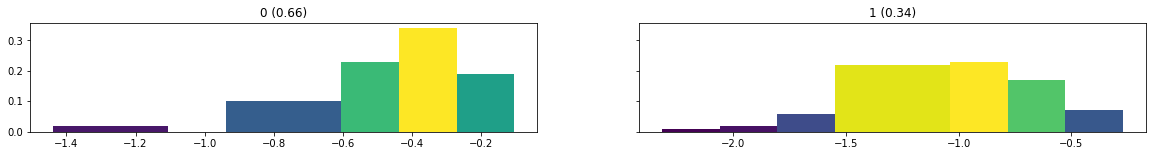

Correct
Real:  0.0


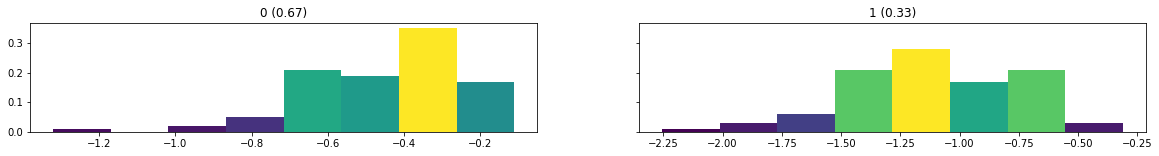

Correct
Summary
Total images:  100
Predicted for:  2
Accuracy when predicted:  1.0
Real:  0.0


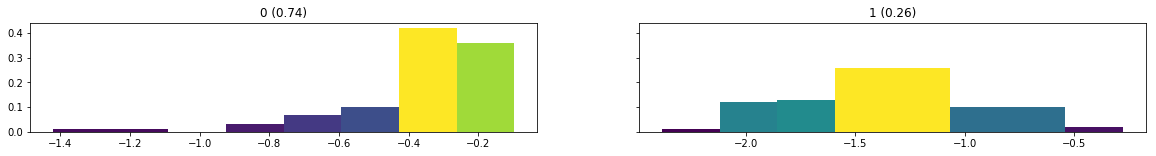

Correct
Real:  1.0


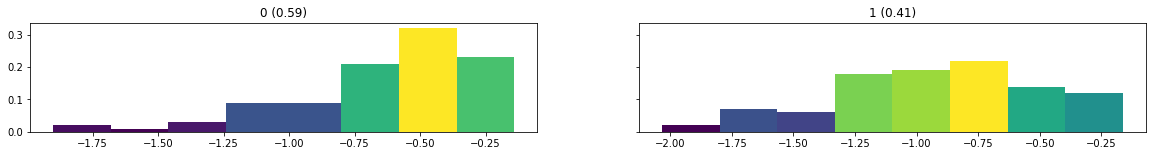

Incorrect :()
Summary
Total images:  100
Predicted for:  2
Accuracy when predicted:  0.5
Real:  1.0


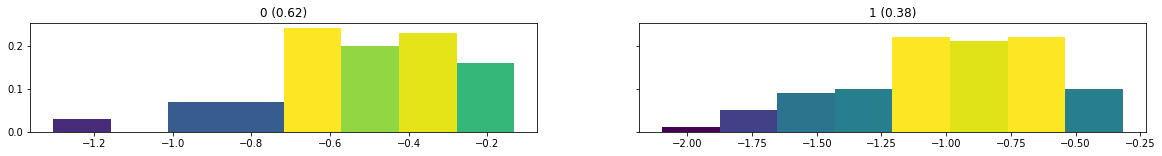

Incorrect :()
Real:  1.0


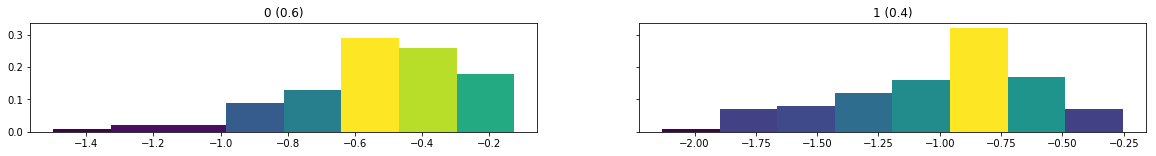

Incorrect :()
Summary
Total images:  100
Predicted for:  2
Accuracy when predicted:  0.0
Real:  1.0


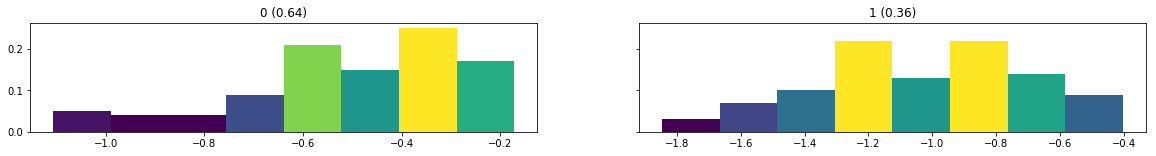

Incorrect :()
Real:  0.0


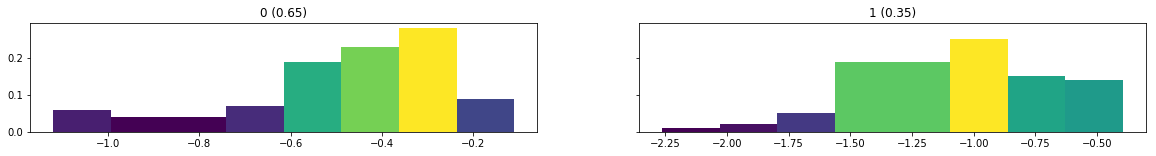

Correct
Summary
Total images:  100
Predicted for:  2
Accuracy when predicted:  0.5
Real:  0.0


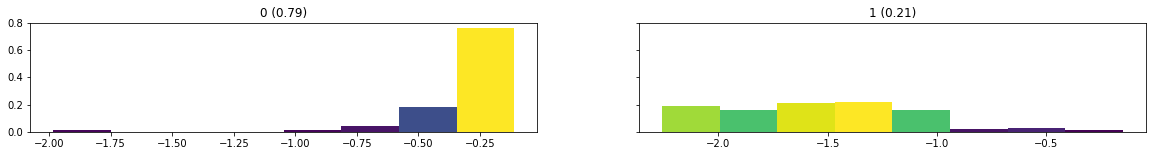

Correct
Real:  0.0


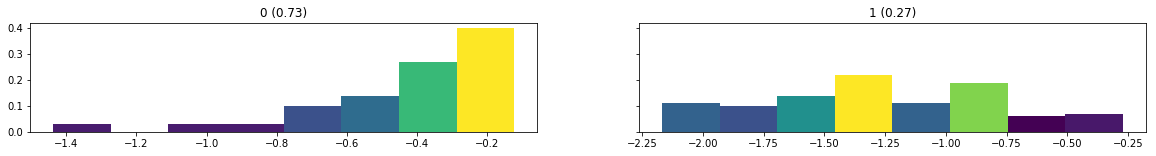

Correct
Summary
Total images:  100
Predicted for:  2
Accuracy when predicted:  1.0
Real:  0.0


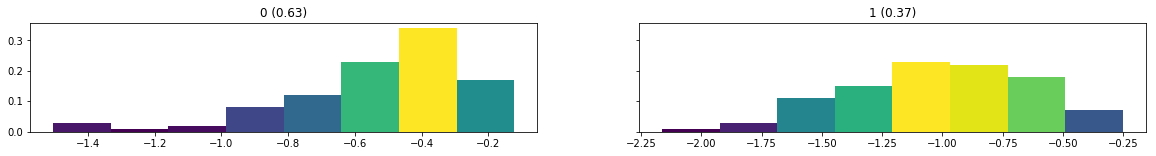

Correct
Real:  0.0


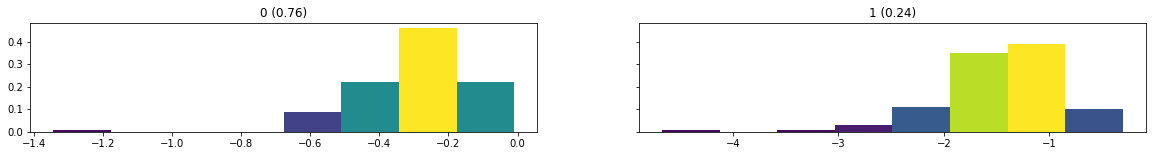

Correct
Summary
Total images:  100
Predicted for:  2
Accuracy when predicted:  1.0
Real:  1.0


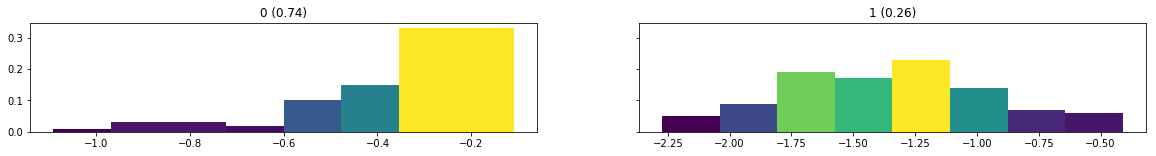

Incorrect :()
Real:  1.0


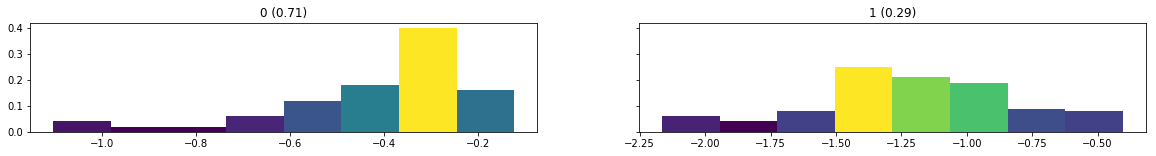

Incorrect :()
Summary
Total images:  100
Predicted for:  2
Accuracy when predicted:  0.0
Real:  1.0


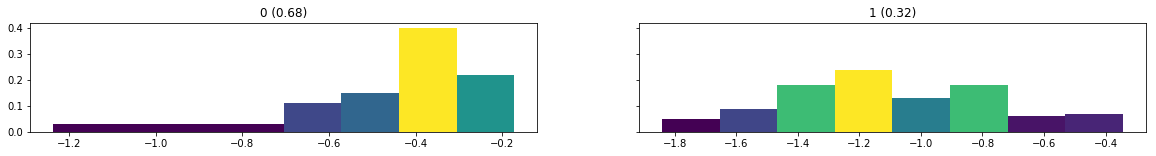

Incorrect :()
Real:  0.0


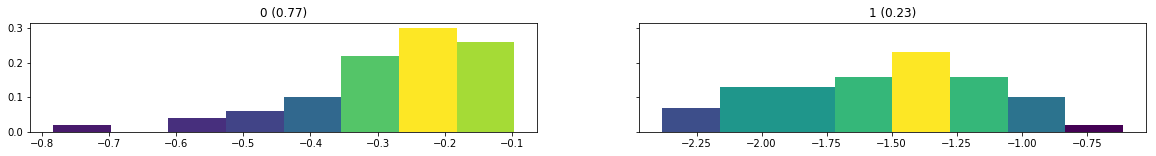

Correct
Summary
Total images:  100
Predicted for:  2
Accuracy when predicted:  0.5
Real:  1.0


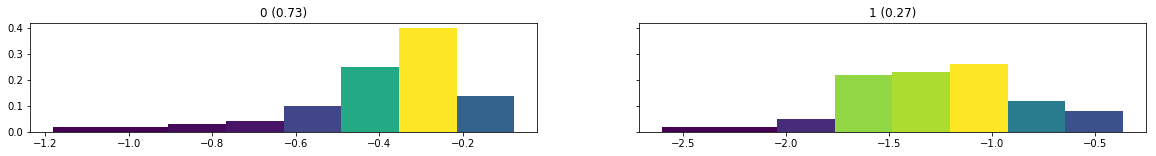

Incorrect :()
Real:  0.0


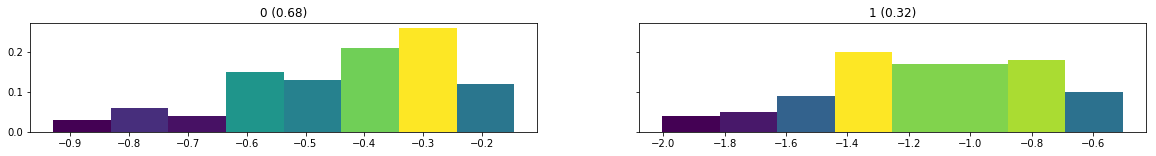

Correct
Summary
Total images:  100
Predicted for:  2
Accuracy when predicted:  0.5
Real:  1.0


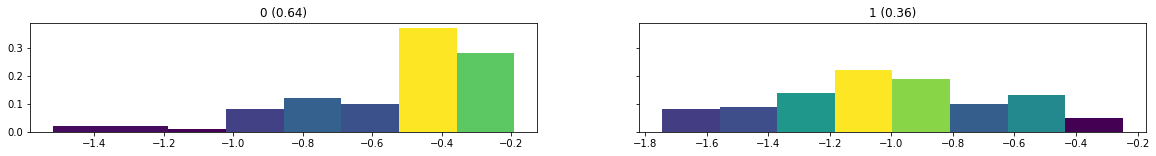

Incorrect :()
Real:  1.0


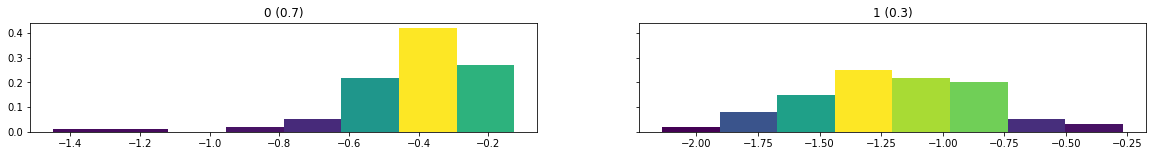

Incorrect :()
Summary
Total images:  100
Predicted for:  2
Accuracy when predicted:  0.0
Real:  1.0


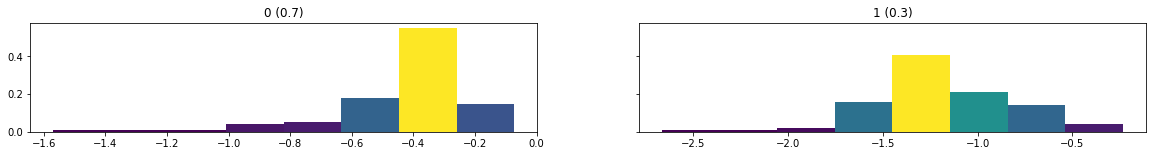

Incorrect :()
Real:  0.0


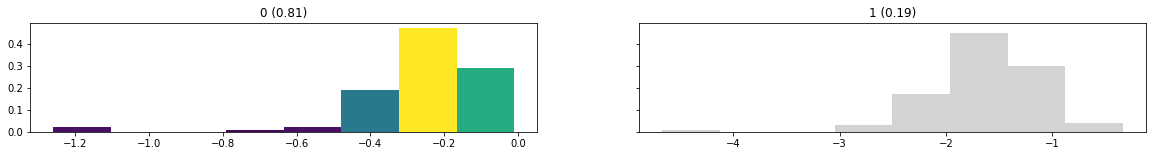

Correct
Summary
Total images:  100
Predicted for:  2
Accuracy when predicted:  0.5
Real:  0.0


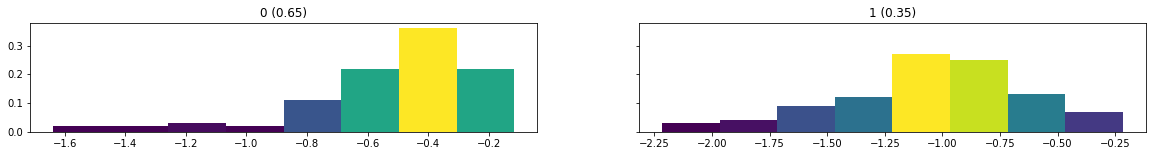

Correct
Real:  1.0


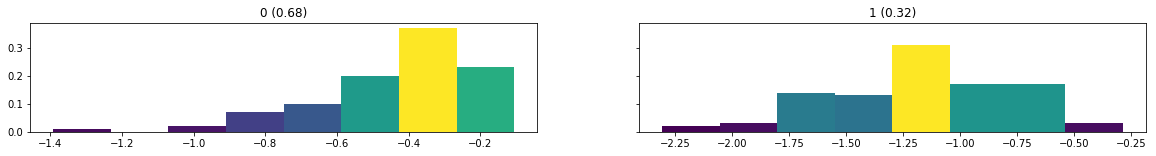

Incorrect :()
Summary
Total images:  100
Predicted for:  2
Accuracy when predicted:  0.5
Real:  1.0


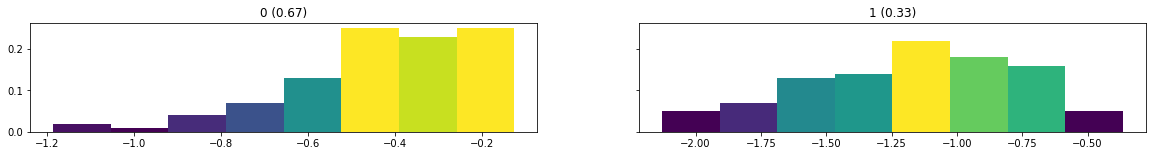

Incorrect :()
Real:  1.0


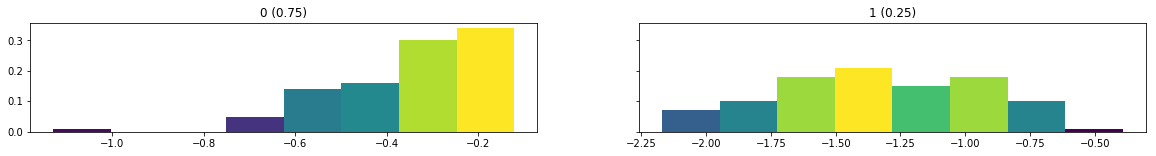

Incorrect :()
Summary
Total images:  100
Predicted for:  2
Accuracy when predicted:  0.0
Real:  0.0


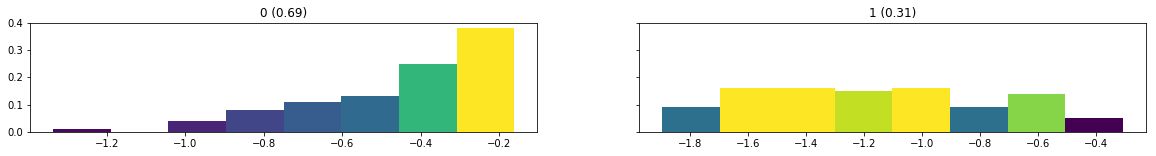

Correct
Real:  0.0


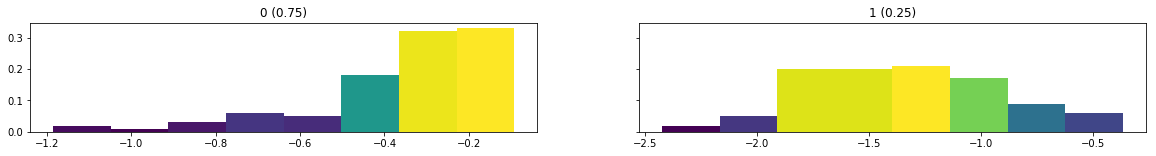

Correct
Summary
Total images:  100
Predicted for:  2
Accuracy when predicted:  1.0
Real:  0.0


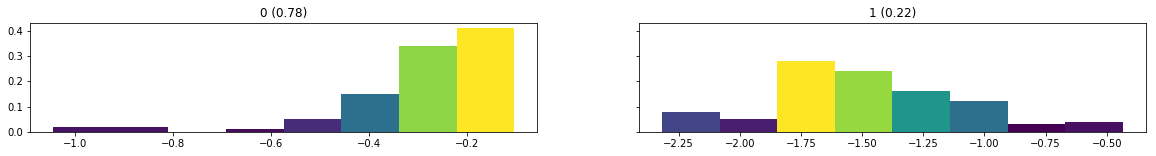

Correct
Real:  1.0


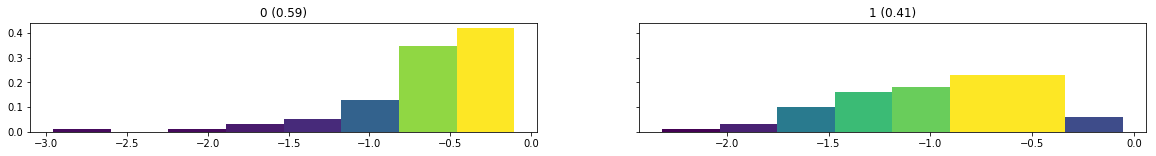

Incorrect :()
Summary
Total images:  100
Predicted for:  2
Accuracy when predicted:  0.5
Real:  1.0


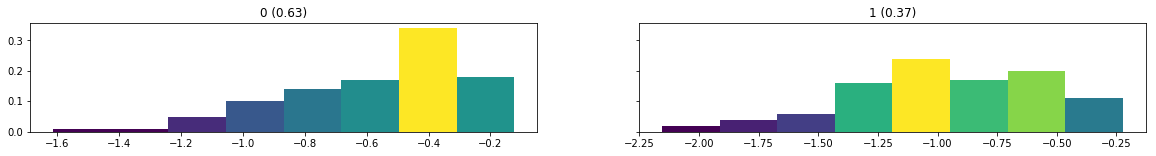

Incorrect :()
Real:  0.0


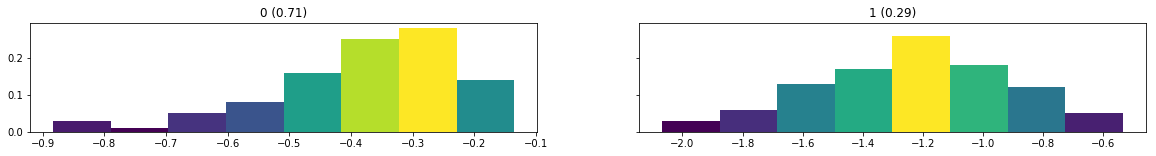

Correct
Summary
Total images:  100
Predicted for:  2
Accuracy when predicted:  0.5
Real:  0.0


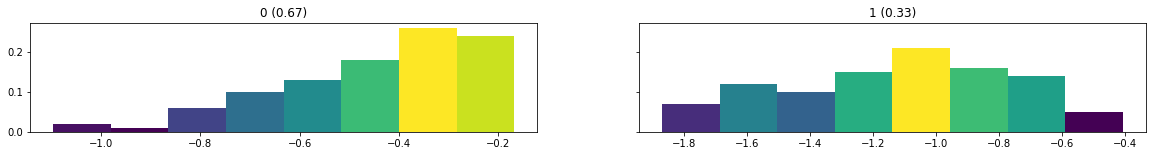

Correct
Real:  0.0


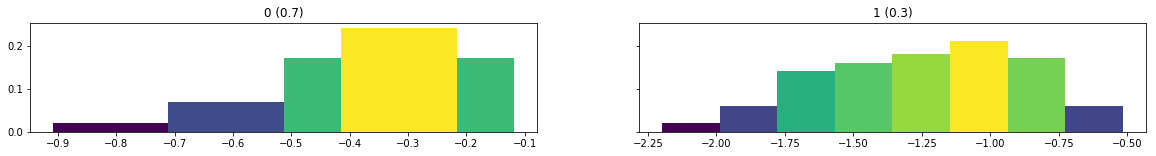

Correct
Summary
Total images:  100
Predicted for:  2
Accuracy when predicted:  1.0
Real:  0.0


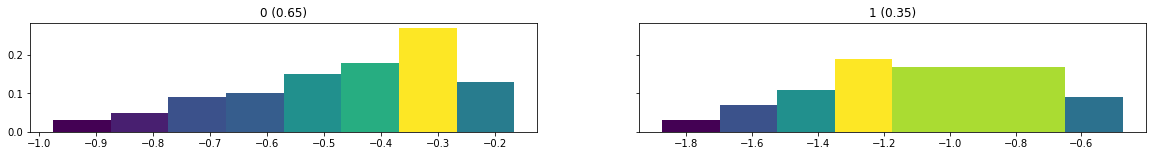

Correct
Real:  0.0


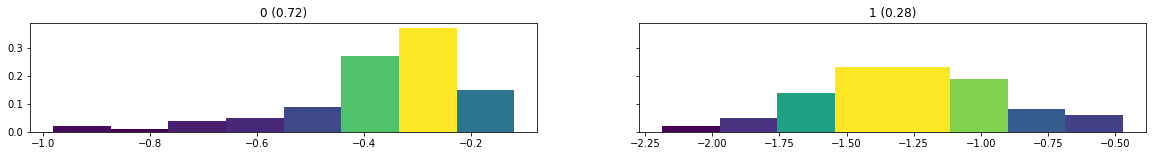

Correct
Summary
Total images:  100
Predicted for:  2
Accuracy when predicted:  1.0
Real:  1.0


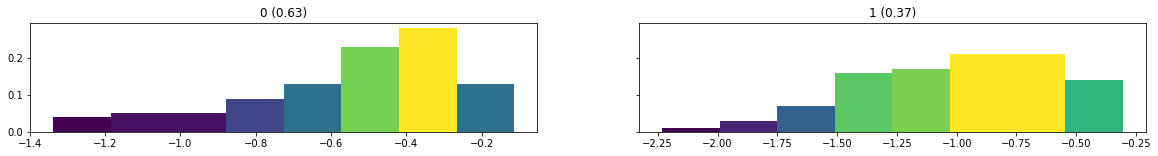

Incorrect :()
Real:  0.0


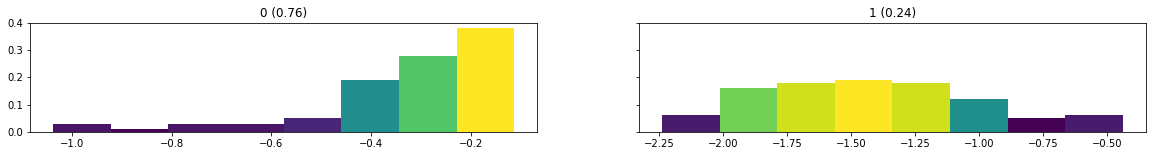

Correct
Summary
Total images:  100
Predicted for:  2
Accuracy when predicted:  0.5
Real:  0.0


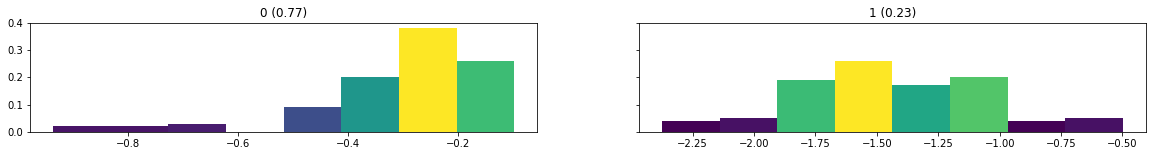

Correct
Real:  0.0


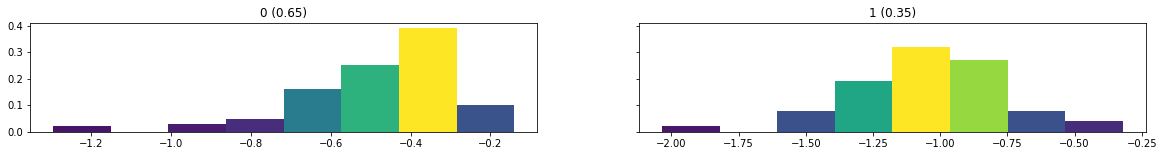

Correct
Summary
Total images:  100
Predicted for:  2
Accuracy when predicted:  1.0
Real:  1.0


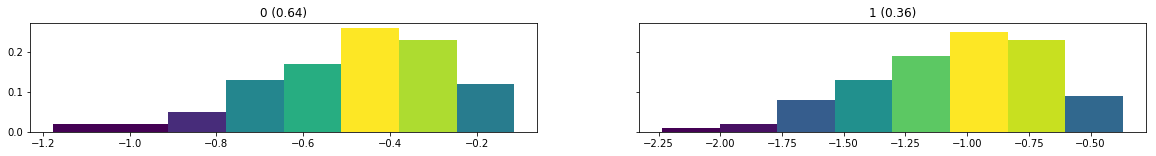

Incorrect :()
Real:  0.0


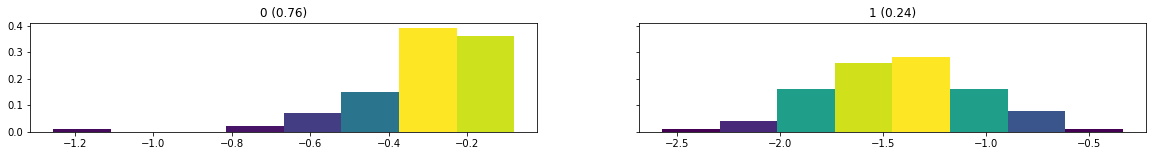

Correct
Summary
Total images:  100
Predicted for:  2
Accuracy when predicted:  0.5
Real:  0.0


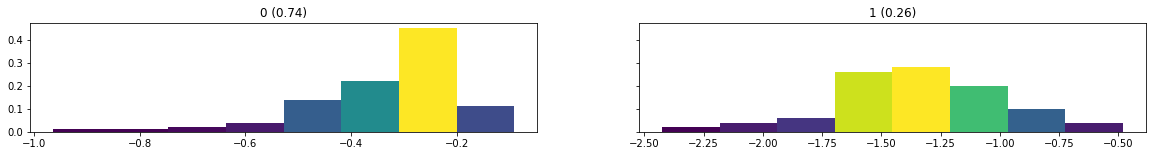

Correct
Real:  1.0


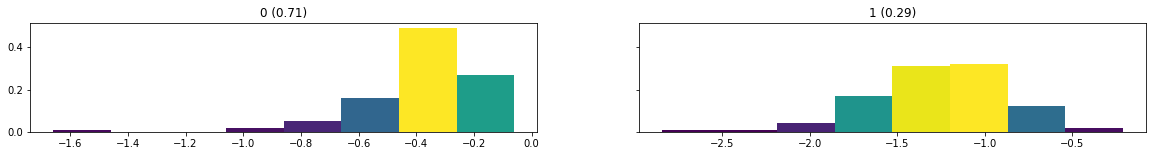

Incorrect :()
Summary
Total images:  100
Predicted for:  2
Accuracy when predicted:  0.5
Real:  0.0


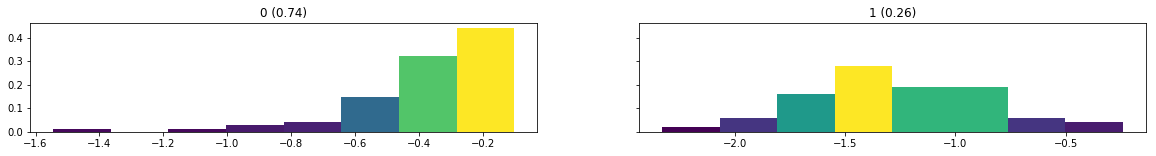

Correct
Real:  0.0


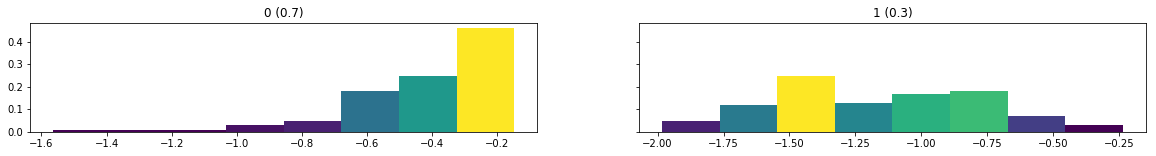

Correct
Summary
Total images:  100
Predicted for:  2
Accuracy when predicted:  1.0
Real:  0.0


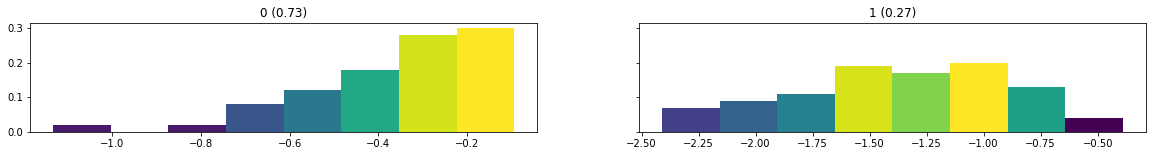

Correct
Real:  0.0


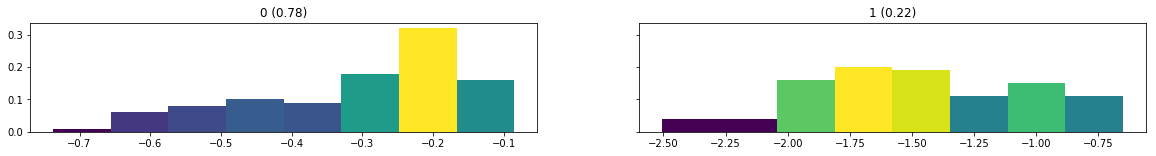

Correct
Summary
Total images:  100
Predicted for:  2
Accuracy when predicted:  1.0
Real:  1.0


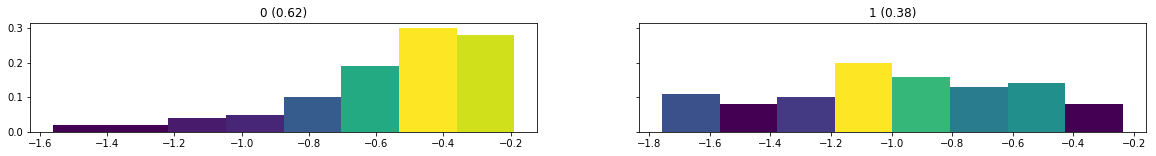

Incorrect :()
Real:  0.0


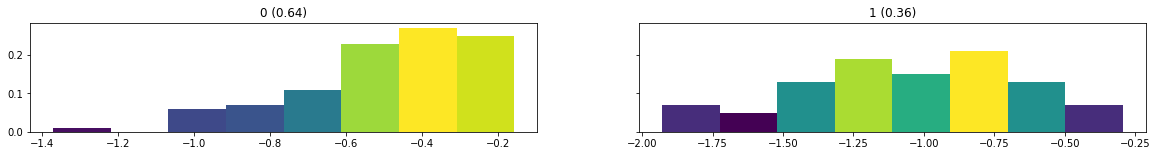

Correct
Summary
Total images:  100
Predicted for:  2
Accuracy when predicted:  0.5
Real:  0.0


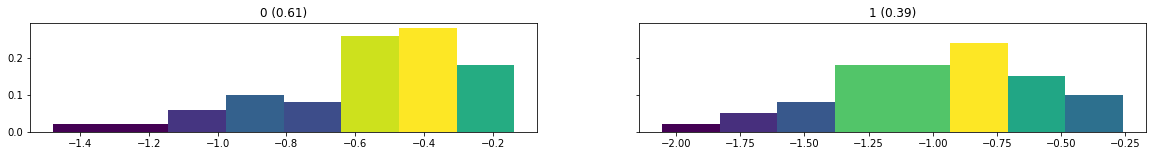

Correct
Real:  0.0


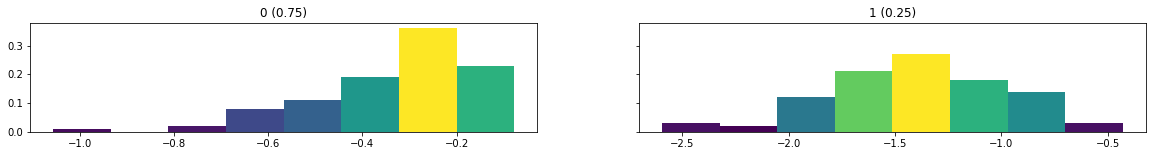

Correct
Summary
Total images:  100
Predicted for:  2
Accuracy when predicted:  1.0
Real:  1.0


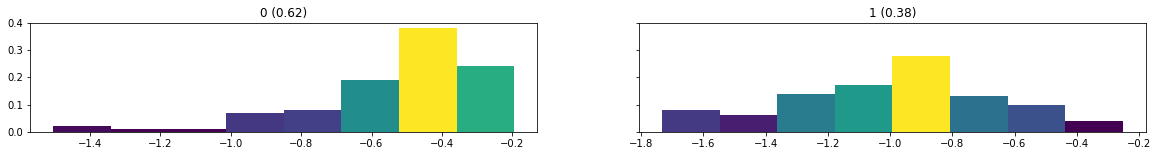

Incorrect :()
Real:  0.0


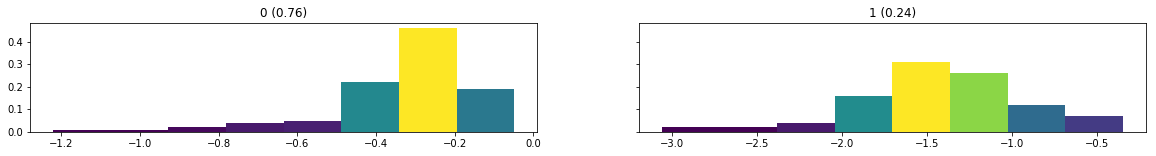

Correct
Summary
Total images:  100
Predicted for:  2
Accuracy when predicted:  0.5
Real:  0.0


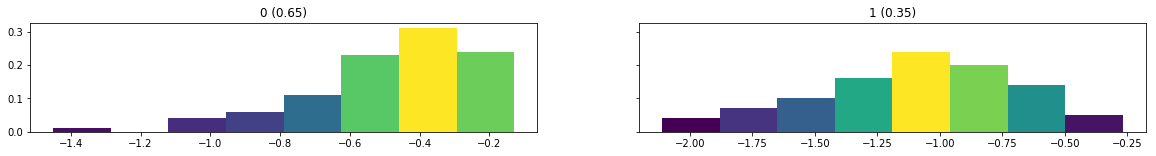

Correct
Real:  0.0


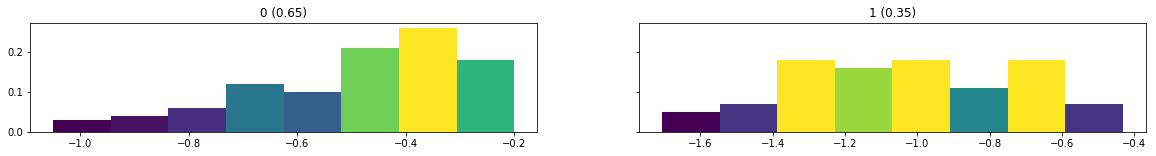

Correct
Summary
Total images:  100
Predicted for:  2
Accuracy when predicted:  1.0
Real:  0.0


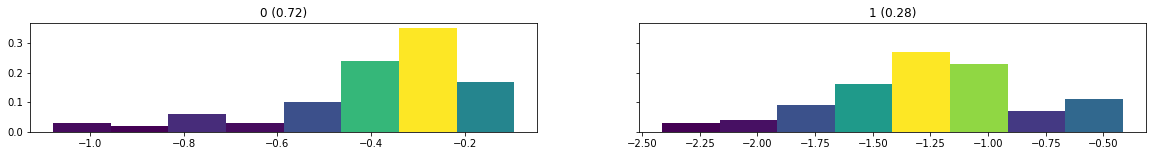

Correct
Real:  0.0


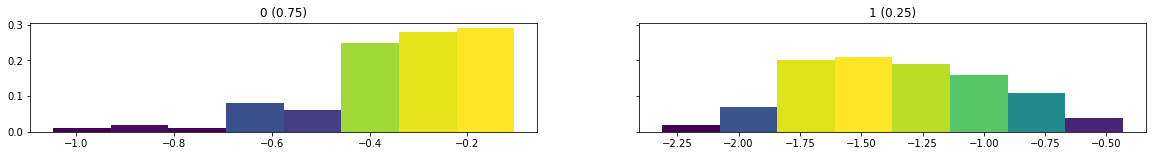

Correct
Summary
Total images:  100
Predicted for:  2
Accuracy when predicted:  1.0
Real:  0.0


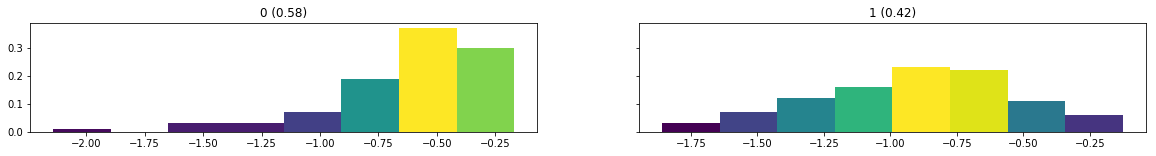

Correct
Real:  1.0


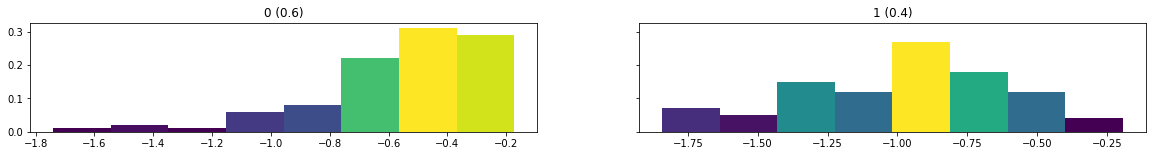

Incorrect :()
Summary
Total images:  100
Predicted for:  2
Accuracy when predicted:  0.5
Real:  1.0


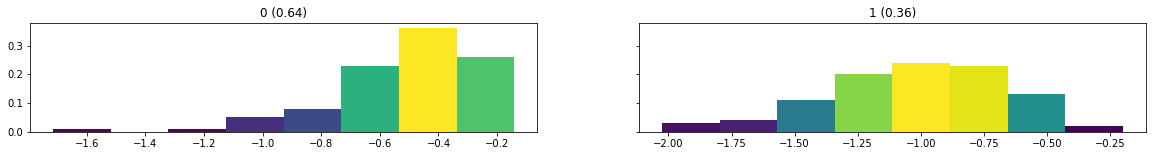

Incorrect :()
Real:  0.0


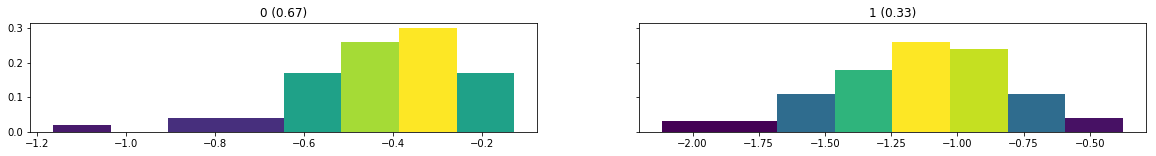

Correct
Summary
Total images:  100
Predicted for:  2
Accuracy when predicted:  0.5
Real:  0.0


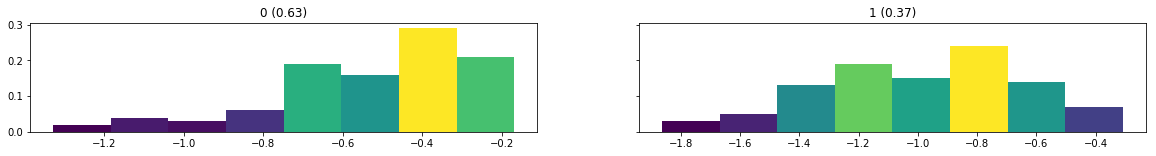

Correct
Real:  0.0


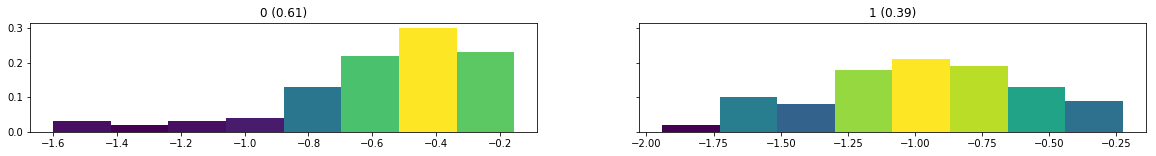

Correct
Summary
Total images:  100
Predicted for:  2
Accuracy when predicted:  1.0
Total images:  7500
Skipped:  7350
Accuracy when made predictions: 68 %


In [27]:
# Prediction when network can decide not to predict
%matplotlib inline
import matplotlib.pyplot as plt

print('Prediction when network can refuse')
correct = 0
total = 0
total_predicted_for = 0
for j, data in enumerate(test_loader):
    images, labels = data
    
    total_minibatch, correct_minibatch, predictions_minibatch = test_batch(images, labels, plot=True)
    total += total_minibatch
    correct += correct_minibatch
    total_predicted_for += predictions_minibatch

print("Total images: ", total)
print("Skipped: ", total-total_predicted_for)
print("Accuracy when made predictions: %d %%" % (100 * correct / total_predicted_for))


In [28]:
# preparing for evaluation
dataiter = iter(test_loader)
images, labels = dataiter.next()

Real:  0.0


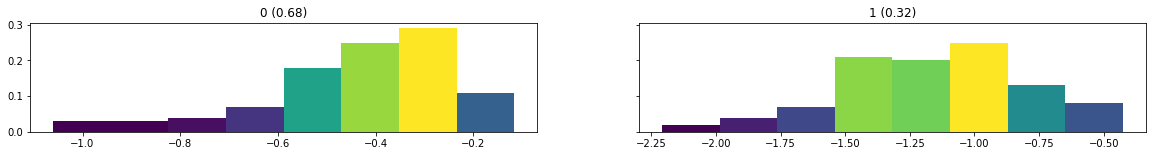

Correct
Real:  1.0


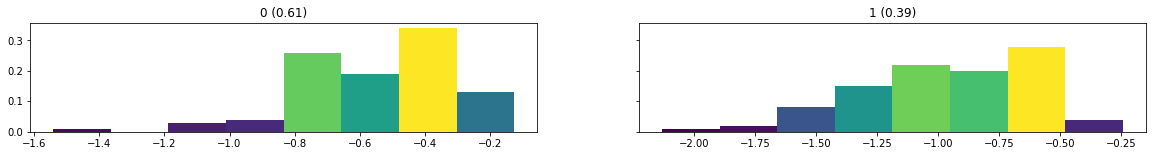

Incorrect :()
Summary
Total images:  100
Predicted for:  2
Accuracy when predicted:  0.5


(100, 1.0, 2)

In [29]:
test_batch(images[:100], labels[:100])

In [30]:
# Prediction when network can decide not to predict

print('Prediction when network can refuse')
total = 0
total_predicted_for = 0
for j, data in enumerate(test_loader):
    images, labels = data
    total_minibatch, correct_minibatch, predictions_minibatch = test_batch(images, labels, plot=False)
    total += total_minibatch
    total_predicted_for += predictions_minibatch

print("Total inputs: ", total)
print("Skipped: ", total-total_predicted_for)

Prediction when network can refuse
Total inputs:  7500
Skipped:  7350
